# Batch Processing of Plots using the Selection for Data

NUE SELECTION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [4]:
# Set False if doing Run 1, True if doing Run 3

isRun3 = False

ending = "Sept19"

## NUE_NUE SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
elif isRun3 == True:
    NUE  = '/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt", 'swtrig_pre',            
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)
nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

['tksh_distance', 'ccnc', 'shr_phi', 'shr_tkfit_dedx_U', 'trk_score_v', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_V', 'slnhits', 'shrsubclusters0', 'npion', 'shr_tkfit_nhits_U', 'CosmicIPAll3D', 'shr_pz', 'reco_nu_vtx_sce_x', 'shrsubclusters2', 'shr_energy_tot_cali', 'slnunhits', 'shr_energy_cali', 'selected', 'shr_energy', 'elec_e', 'swtrig_pre', 'shr_theta', 'reco_nu_vtx_sce_z', 'topological_score', 'flash_time', 'shr_score', 'n_showers', 'category', 'run', 'shr_tkfit_dedx_V', 'proton_e', 'trk_energy_tot', 'shr_tkfit_npoints', 'shrmoliereavg', 'shr_px', 'tksh_angle', 'shr_tkfit_nhits_Y', 'trkshrhitdist2', 'nproton', 'npi0', 'shrsubclusters1', 'trk_energy', 'n_tracks_contained', 'n_tracks', 'contained_fraction', 'sub', 'shr_distance', 'evt', 'nu_pdg', 'nslice', 'shr_py', 'reco_nu_vtx_sce_y', 'n_showers_contained', 'hits_ratio']


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    nue_intrinsic_pot = 2.37838E22 #matches Alex
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    nue_intrinsic_pot = 2.5345e+22

nue_nue['pot_scale'] = beamon_pot/nue_intrinsic_pot

In [9]:
nue_nue['totweight_data'] = nue_nue['pot_scale']*nue_nue['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  4.438872337341309


In [13]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0              NaN
1         1.504711
2        -0.197600
3         0.142221
4         0.128535
            ...   
127546    0.195821
127547    2.786030
127548    1.216194
127549         NaN
127550    0.975678
Name: elec_px_asmuon, Length: 127551, dtype: float64
time to run:  90.38442182540894


In [14]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [15]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  10.665127038955688


In [16]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [17]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [18]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [19]:
"""
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
"""

"\nfor i,df in enumerate(df_v):\n\n    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)\n                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)\n                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)\n                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)\n                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)\n"

In [20]:
# add back the cosmic category, for background only
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [21]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [22]:
#Define signal catagories

#nue_nue["is_signal"] = nue_nue["category"] == 11

In [23]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [24]:
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for Selection.

In [24]:

reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'


In [25]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3==True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')

In [26]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 120)


In [27]:
test = np.nansum(nue_nue.query(BDT_LOOSE_CUTS)["weightSplineTimesTuneTimesPPFX"])
print('total signal events = '+ str(test))

total signal events = 13163.879


In [28]:
datasets_bdt = nue_nue

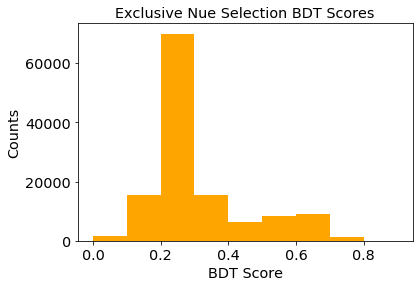

In [29]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [30]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
#if lepton mom (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)

In [31]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
#ENERGY
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
#ANGLE
#NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0'
#NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0'
#LEPTON MOM
NUE_SEL_QUERY += ' and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5'
NUE_SEL_QUERY += ' and targetP_asmuon > 0.04 & targetP_asmuon < 5'

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'

#ending = "Sept19"

In [32]:
#New categories

for i,df in enumerate(df_v):
            
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [33]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 57.85580979000727


In [34]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY + 'and is_signal==True')['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 53.773053813848165


In [35]:
test = np.nansum(datasets_bdt.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 53.773053813848165


In [36]:
#truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
#truthsel_nue  += " and category == 11"
#truthsel_nue += ' and reco_e > 0.04 and reco_e < 5'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  127551
n_events/2 here =  25510.0

1.0
1
127551
{'nue_nue': 1}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5 and targetP_asmuon > 0.04 & targetP_asmuon < 5 and BDT_score > 0.55& targetP_asmuon_reco <= 5 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.01028306 0.00998801 0.01302625 ... 0.00941022 0.00871911 0.00935456]
current_total  57.85580979000727
57.855809790007270976275322027504444122314453125000000000000000000000000000000
-----------------

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
0
{'nue_nue': 1}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5 and targetP_asmuon > 0.04 & targetP_asmuon < 5 and BDT_score > 0.55& targetP_asmuon_reco <= 5 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[]
Had to return early (colour sorting).


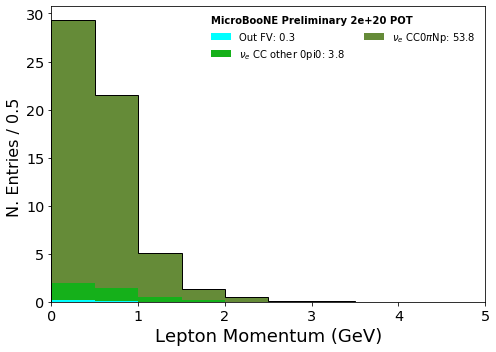

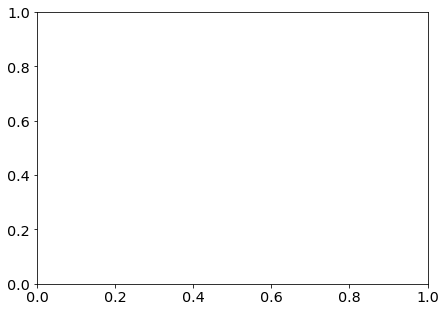

In [37]:
#WHAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    # NUE
    weights = { #full sample mc = 0.38
                #"nue_nue"  : nueratio  * SPLIT * scaling
                "nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.05, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= BDT_LOOSE_CUTS,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        #genieweight = "weightSplineTimesTuneTimesPPFX",
        genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  127551
n_events/2 here =  25510.0

1.0
1
127551
{'nue_nue': 0.008409085175623745}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5 and targetP_asmuon > 0.04 & targetP_asmuon < 5 and BDT_score > 0.55and is_signal==True& targetP_asmuon_reco <= 5 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[1.2228513 1.1877642 1.5490692 ... 1.1190536 1.0368681 1.1124349]
current_total  53.77305381384816
53.7730538138481577448146708775311708450317382812500000000000000

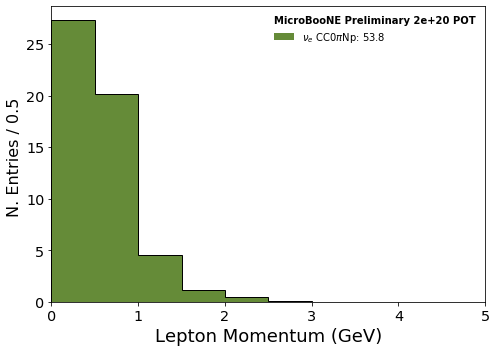

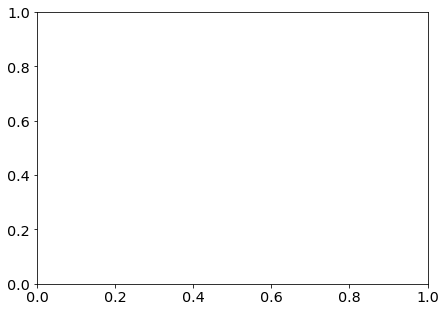

In [43]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUE_SEL_QUERY,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


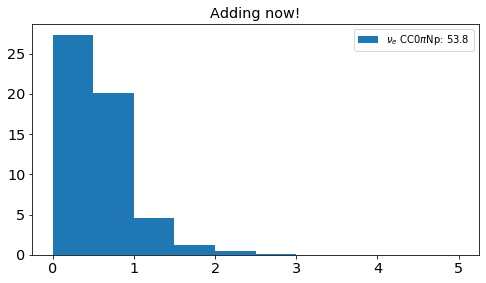

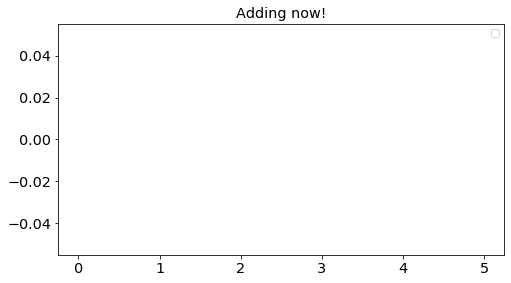

In [44]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0.04, 5.0])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [45]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

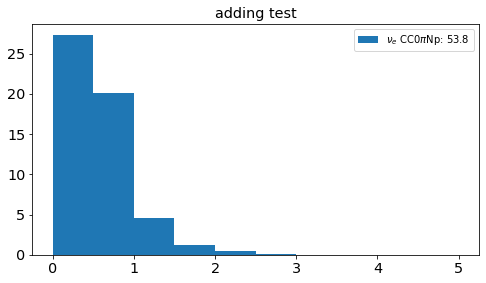

In [46]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}

labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0.0, 5.0])
#nue_ax1.set_ylim([0, 60])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 35])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()


#print('%.75f' % sum(nue_stacked[0]))
#print(nue_stacked[0])

In [47]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0 #2

nue_wanted_list = nue_stacked[0]
#nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

#2 for not signal, 0 for signal
print(nue_wanted_list[0])
print(sum(nue_wanted_list[0]))

#print('%.75f' % nue_wanted_list[9])

27.280086606430867


TypeError: 'numpy.float64' object is not iterable

In [48]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True


if isRun3 == False:
    if (is_selected == True):
        ######full trueE
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection._selectedsig_'+ending+'csv')
        ########leptonMom
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
if isRun3 == True:
    if (is_selected == True):
        ######full trueE
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_run3_usingSelection_selectedsig_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_run3_usingSelection_selectedsig_run3_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection._selectedsig_run3_'+ending+'csv')
    elif (is_selected == False):
        ######full trueE
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_run3_usingSelection_allselected_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_run3_usingSelection_allselected_run3_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom__usingSelection_allselected_run3_'+ending+'.csv')

### Stat Errors

In [97]:
#This is the stat errors on the selected signal nue

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= SIGNAL_NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR DETSYS
None
err nue: 
[0.01291511 0.02504748 0.02191655 0.03991942 0.06888057 0.08179568
 0.11036546 0.20507624 0.34635969 0.87587907]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 0.7

In [98]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.01291510698231441, 0.025047480208124914, 0.021916545182109302, 0.03991942158169909, 0.06888057057234351, 0.08179567755465791, 0.1103654596670504, 0.20507624420402273, 0.3463596872529773, 0.8758790735278681]

total selected =  [0.7442759871482849, 1.3225942850112915, 1.13639497756958, 2.110206365585327, 3.6685400009155273, 4.124837398529053, 6.128730297088623, 10.993517875671387, 18.76677894592285, 51.67842483520508]


In [99]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
if isRun3 == True:
    """
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

In [100]:
#This is the stat errors on the selected NOT signal nue

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NOT_SIGNAL_NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575and is_signal==False 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR DETSYS
None
err nue: 
[0.00313094 0.00078273 0.0023482  0.0035223  0.00547914 0.00743597
 0.00861007 0.01252374 0.03483165 0.11741006]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0.1

In [101]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.003130935026015614, 0.0007827337565039035, 0.0023482012695117105, 0.0035223019042675656, 0.005479136295527326, 0.007435970686787084, 0.008610071321542938, 0.012523740104062457, 0.03483165216442371, 0.11741006347558554]

total selected =  [0.14997214078903198, 0.03067239187657833, 0.0969276875257492, 0.13421808183193207, 0.2475779801607132, 0.3525511920452118, 0.36807307600975037, 0.5835567712783813, 1.6973450183868408, 5.467469692230225]


In [102]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
if isRun3 == True:
    """
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [103]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1291   408   220   316   614  1208   713   788   682   385  ...  1035   
1     1228   256   748   403   693  1026  1895   837   626   513  ...

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 0.89424813  1.3532666   1.23332262  2.24442434  3.91611767  4.47738934
  6.49680328 11.57707405 20.46412277 57.14588928]


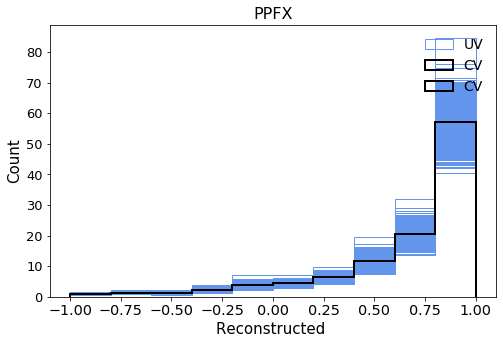

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


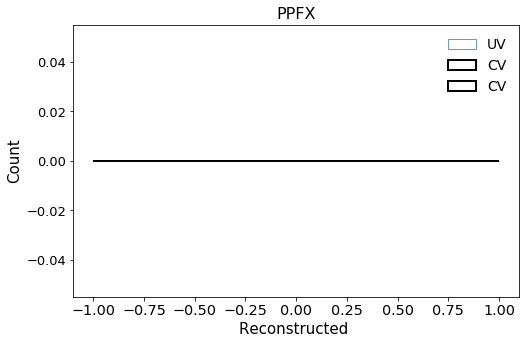

In [104]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [105]:
#will need to edit this if batching

nue_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)
if isRun3 == False:
    #nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [106]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
print(total_ppfx_df_splines)

entry
12        0.017510
23        0.022237
66        0.020542
76        0.016724
176       0.022730
            ...   
124224    0.016703
124226    0.016488
124233    0.020677
124247    0.015230
124278    0.012700
Name: weightSplineTimesTuneTimesPPFX, Length: 5070, dtype: float32


In [107]:
if isRun3 == False: 
    """
    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')
    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')
    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [108]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1    2     3     4     5     6     7     8     9    ...   590  \
0     1431  1044  819  1334  1086  1501  1160  1198  1365  1369  ...  1447   
1     1393  1073  871  1317  1108  1452  1171  1208  1343  1342  ...  1

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 0.89424813  1.3532666   1.23332262  2.24442434  3.91611767  4.47738934
  6.49680328 11.57707405 20.46412277 57.14588928]


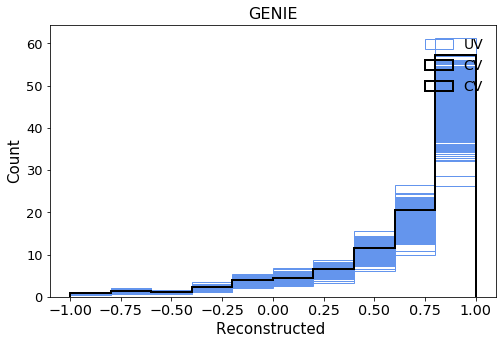

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


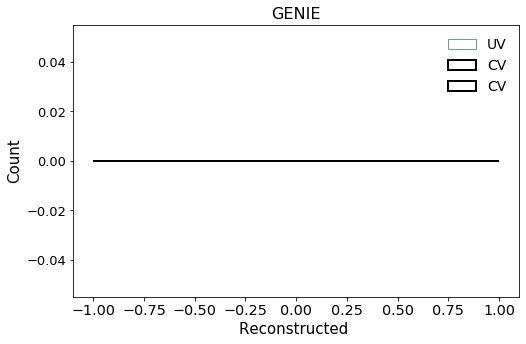

In [109]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [110]:
#will need to edit this if batching

nue_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')  
    nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv') 
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv') 

In [111]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [112]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################
    #typo missing _
    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [113]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#this time = nevents
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0
weightsReint
1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1006   980  1085   992  1041   981   896   992   970  1029  ...   926   
1      936   826  1092  1010   895   970   974   955  108

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 0.89424813  1.3532666   1.23332262  2.24442434  3.91611767  4.47738934
  6.49680328 11.57707405 20.46412277 57.14588928]


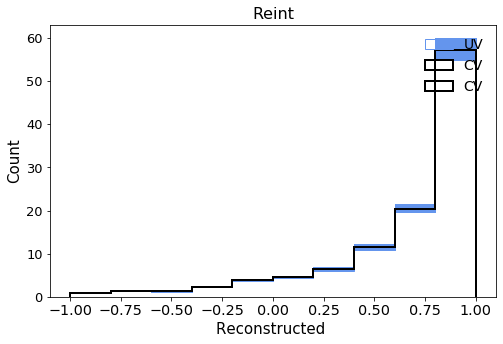

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


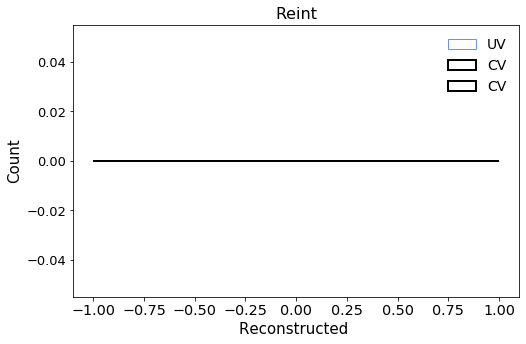

In [114]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [115]:
#will need to edit this if batching

nue_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv') 
    nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv') 
    #nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [116]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)
print(final_ncvs_nue_nue_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)

[ 0.89424813  1.35326672  1.23332262  2.24442458  3.91611791  4.47738886
  6.49680328 11.577075   20.46412468 57.1458931 ]
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1006   980  1085   992  1041   981   896   992   970  1029  ...   926   
1      936   826  1092  1010   895   970   974   955  1089   952  ...   924   
2      864   618  1415  1012   822   902   789   885  1179   933  ...   731   
3      948   852  1097  1007   921   971   955   961  1069   966  ...   920   
4      986   959  1027  1001   980   991   984   989  1016   992  ...   976   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5065  1132  1405   704   984  1186  1083  1142  1105   832  1073  ...  1233   
5066  1007  1035   757  1009   945  1048  1212  1031   991   962  ...  1160   
5067   968   908  1050  1004   947   984   982   977  1043   977  ...   957   
5068  1071  1234   707   998  1056  1074  1220  1074   913  1011  ...  1232   
5069   9

In [117]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [50]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#was I out of it choosing batch sizes?!
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0
1.0
2
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]


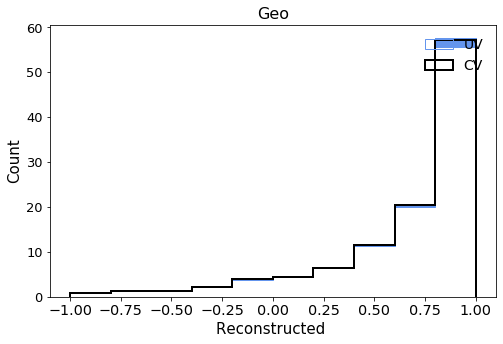

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]


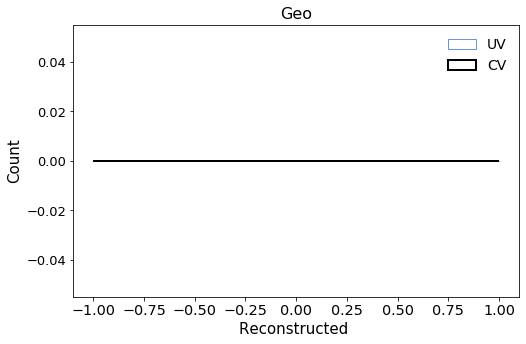

In [51]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    #current = (plt.hist(bin_centers, bins, histtype='step', 
    #                 weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    #print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [52]:
#will need to edit this if batching

nue_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv') 
    nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [53]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [54]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """
    


## NUE_MC SAMPLE

In [5]:
import time
s = time.time()

# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTun
elif isRun3 == True:
    NU   = '/neutrinoselection_filt_run3b_overlay'    +ls.APPEND #newTun
        

#actually fetch datasets
nue_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt", "swtrig_pre",            
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc  = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

#just prints out the time this cell takes
print("==============================")
s2 = time.time()
print ("time to run: ",s2-s)

['topological_score', 'shr_tkfit_nhits_U', 'tksh_angle', 'shr_score', 'contained_fraction', 'n_showers', 'trk_score_v', 'hits_ratio', 'proton_e', 'tksh_distance', 'slnhits', 'nproton', 'nu_pdg', 'CosmicIPAll3D', 'shrmoliereavg', 'ccnc', 'shr_tkfit_dedx_U', 'shr_tkfit_dedx_V', 'shr_tkfit_nhits_Y', 'elec_e', 'n_showers_contained', 'shr_tkfit_dedx_Y', 'n_tracks_contained', 'evt', 'selected', 'npion', 'trk_energy', 'shr_tkfit_npoints', 'nslice', 'shr_theta', 'shr_tkfit_nhits_V', 'reco_nu_vtx_sce_z', 'n_tracks', 'shrsubclusters1', 'swtrig_pre', 'shr_py', 'shrsubclusters2', 'sub', 'trkshrhitdist2', 'reco_nu_vtx_sce_x', 'run', 'category', 'shr_distance', 'shr_phi', 'shr_energy_cali', 'slnunhits', 'flash_time', 'shr_energy_tot_cali', 'shr_energy', 'shr_pz', 'trk_energy_tot', 'reco_nu_vtx_sce_y', 'npi0', 'shr_px', 'shrsubclusters0']
time to run:  1183.771176815033


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33652E21
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    overlay_pot =  1.98937e+21    

nue_mc['pot_scale'] = beamon_pot/overlay_pot

In [9]:
nue_mc['totweight_data'] = nue_mc['pot_scale']*nue_mc['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#RECO VARIABLE

#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    #df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])

In [13]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
914724   NaN
914725   NaN
914726   NaN
914727   NaN
914728   NaN
Name: elec_px_asmuon, Length: 914729, dtype: float64
time to run:  116.44339561462402


In [14]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [15]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  195.88493180274963


In [16]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [17]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [18]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [16]:
#for i,df in enumerate(df_v):
#
#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [17]:
# add back the cosmic category, for background only
#df_v = [nue_mc]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [19]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [20]:
#Define signal catagories

#nue_mc["is_signal"] = nue_mc["category"] == 11

In [20]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

In [21]:
#df_v = [nue_mc]
#for i,df in enumerate(df_v):
#    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for selection.

In [21]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [22]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')

In [23]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 137)


In [24]:
datasets_bdt = nue_mc

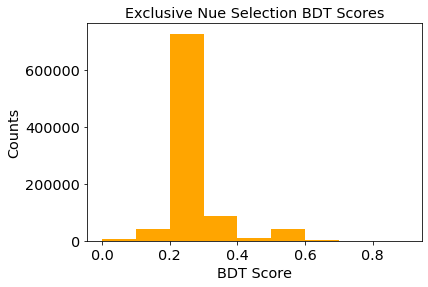

In [25]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [26]:
df_v = [nue_mc]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

#energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
#if lepton mom (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)

In [27]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
#ENERGY
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
#ANGLE
NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0'
NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0'
#LEPTON MOM
#NUE_SEL_QUERY += ' and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5'
#NUE_SEL_QUERY += ' and targetP_asmuon > 0.04 & targetP_asmuon < 5'

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    


SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

#ending = "Sept19"

In [28]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1) & (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [29]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(nue_mc.query(nueCC_query))))
len1 = len(nue_mc)

idx = nue_mc.query(nueCC_query).index
nue_mc.drop(idx, inplace=True)
len2 = len(nue_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))


# of nueCC in AV in overlay sample = 12646
# of nueCC in AV dropped in overlay = 12646


In [33]:
test = np.nansum(nue_mc.query(SIGNAL_NUE_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(NUE_SEL_QUERY + "and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

test = np.nansum(nue_mc.query(BDT_LOOSE_CUTS)['totweight_data'])
print('total signal events = '+ str(test))

test = np.nansum(nue_mc.query("cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query("cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query("cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0")['totweight_data'])
print('total signal events = '+ str(test))

#more mc events

total signal events = 0.0
total signal events = 0.0
total signal events = 0.0
total signal events = 0.0
total signal events = 100.83197080720868
total signal events = 76065.0607148506
total signal events = 1162.3364711378483
total signal events = 1162.3364711378483


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  738787

1.0
1
0
738787
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_mc
--------------------------------------
current sample is:  nue_mc
Had to return early (colour sorting).
738787
0
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 

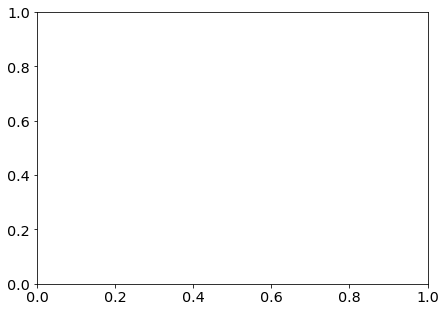

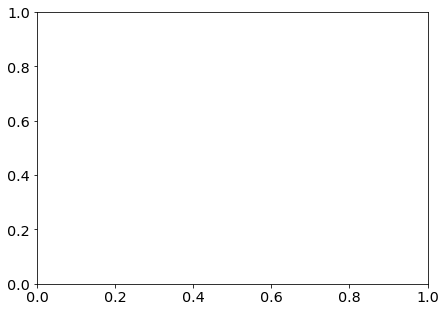

In [71]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/3.3))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    # NU
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= "nslice==1",
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


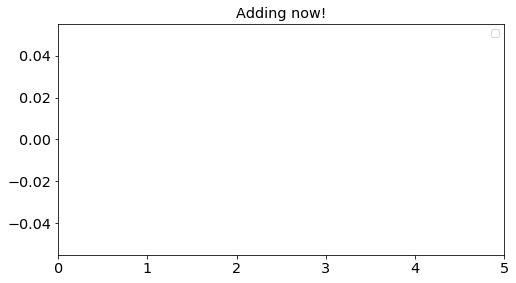

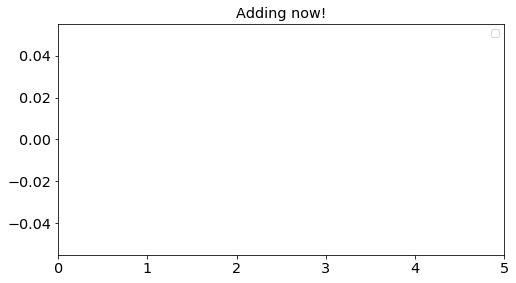

In [72]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [73]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


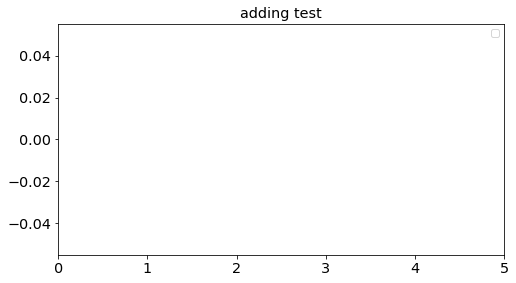

In [74]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 15])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 2])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [75]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [76]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 ==True:
    ######full trueE
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')    

### Stat Errors

In [77]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  738787
n_events/2 here =  369393.0

1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  nue_mc

LOOK HERE FOR DETSYS
None
err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==

In [78]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_mc_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [79]:
if isRun3 == False:
    """
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [80]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  738787
n_events/2 here =  369393.0

1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
extra query added.
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


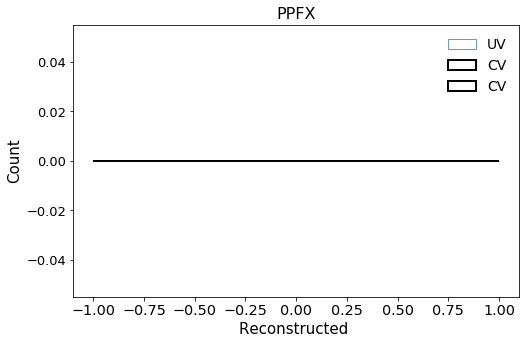

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


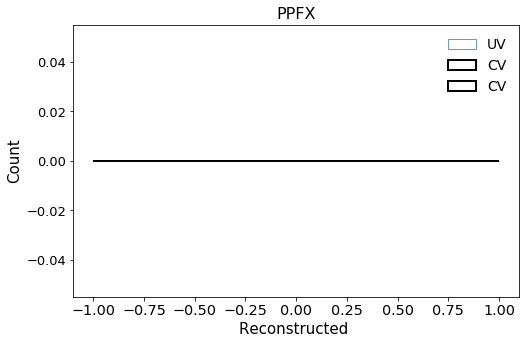

In [81]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [82]:
#will need to edit this if batching

nue_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [83]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [84]:
if isRun3 == False:
    """
    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')


    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')


    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [85]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }  


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  738787
n_events/2 here =  369393.0

1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
extra query added.
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


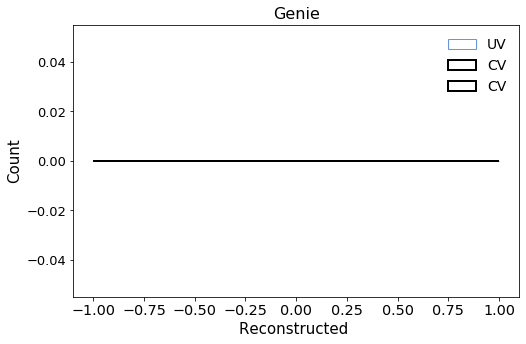

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


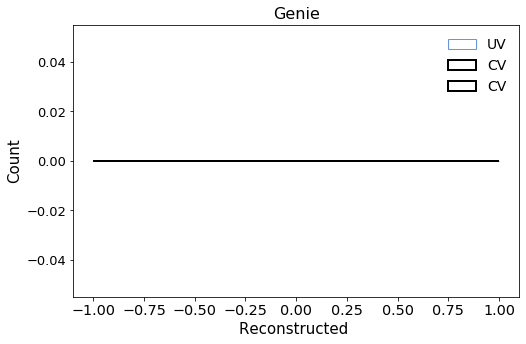

In [86]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [87]:
#will need to edit this if batching

nue_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv') 
    nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [88]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_genie.append(sum(masterlist[a]))

final_ncvs_nue_mc_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)

In [89]:
if isRun3 == False:
    """
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [90]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  738787
n_events/2 here =  369393.0
weightsReint
1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
extra query added.
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


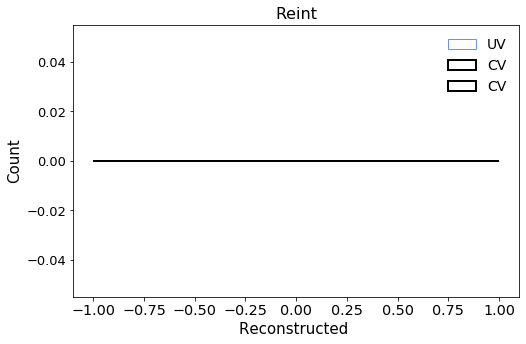

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


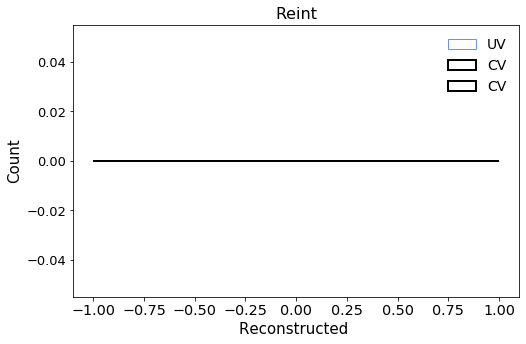

In [91]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [92]:
#will need to edit this if batching

nue_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [93]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_reint.append(sum(masterlist[a]))

final_ncvs_nue_mc_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [94]:
if isRun3 == False:
    """
    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_run3_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_run3_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_run3_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """
        

In [95]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#batch_size = 20000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  738787
n_events/2 here =  369393.0
1.0
2
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
dict_keys(['CV'])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


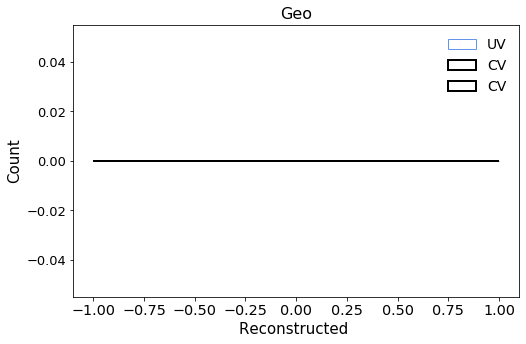

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
dict_keys(['CV'])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


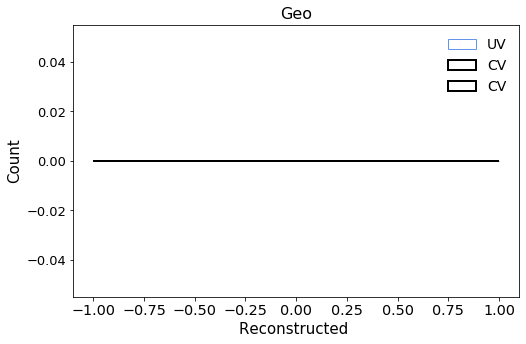

In [96]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 
    print(detvar_dicts[j].keys())


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [97]:
#will need to edit this if batching

nue_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)
if isRun3 == False:
    #nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')   
    nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [98]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_geo.append(sum(masterlist[a]))

final_ncvs_nue_mc_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_mc_geo)):
    final_ns_nue_mc_geo[x] = np.concatenate((final_ns_nue_mc_geo[x][0], final_ns_nue_mc_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [99]:
if isRun3 == False:
    """
    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """
        

## NUE_DIRT SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
if isRun3 == False:
    DRT  = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'        +ls.APPEND
elif isRun3 == True:
    DRT  = 'neutrinoselection_filt_run3b_dirt_overlay'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt", "swtrig_pre",             
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)

['contained_fraction', 'nproton', 'shr_theta', 'shr_tkfit_dedx_U', 'n_tracks_contained', 'npion', 'trkshrhitdist2', 'shr_pz', 'shr_tkfit_npoints', 'tksh_angle', 'shr_tkfit_nhits_Y', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'nu_pdg', 'nslice', 'n_tracks', 'shr_energy_cali', 'selected', 'swtrig_pre', 'shr_tkfit_nhits_U', 'run', 'slnhits', 'shr_tkfit_nhits_V', 'shr_score', 'topological_score', 'shrmoliereavg', 'trk_energy', 'shrsubclusters1', 'shr_tkfit_dedx_Y', 'shr_py', 'shrsubclusters0', 'n_showers', 'flash_time', 'sub', 'shr_tkfit_dedx_V', 'proton_e', 'shrsubclusters2', 'reco_nu_vtx_sce_z', 'hits_ratio', 'evt', 'trk_energy_tot', 'trk_score_v', 'slnunhits', 'shr_distance', 'shr_energy_tot_cali', 'npi0', 'ccnc', 'CosmicIPAll3D', 'shr_phi', 'shr_px', 'category', 'tksh_distance', 'shr_energy', 'n_showers_contained', 'elec_e']


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    dirt_pot =  1.42143e+21
    scalingDRT = 0.65 #0.35
elif isRun3 == True:
    beamon_pot = 5.014E20
    dirt_pot =  1.03226e+21
    scalingDRT = 0.45 

nue_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [9]:
nue_dirt['totweight_data'] = nue_dirt['pot_scale']*nue_dirt['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  14.790386438369751


In [13]:
#TRUTH VARIABLE

import time
s = time.time()

print(df["mc_pdg"])

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        if (len(df["mc_pdg"].iloc[j]) !=0):
            pdg_vector = df["mc_pdg"].iloc[j][0]
            px_vector = df["mc_px"].iloc[j]
            py_vector = df["mc_py"].iloc[j]
            pz_vector = df["mc_pz"].iloc[j]
            result = np.where(pdg_vector==11)[0]
            if np.size(result):
                df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
                df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
                df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0              [13]
1         [14, -13]
2             [-13]
3              [13]
4              [13]
            ...    
389259       [2212]
389260           []
389261           []
389262           []
389263       [2212]
Name: mc_pdg, Length: 389264, dtype: object
entry
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
389259   NaN
389260   NaN
389261   NaN
389262   NaN
389263   NaN
Name: elec_px_asmuon, Length: 389264, dtype: float64
time to run:  8.145714521408081


In [14]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [15]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  34.91128373146057


In [16]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [17]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [18]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [16]:
#for i,df in enumerate(df_v):#

#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [17]:
# add back the cosmic category, for background only
#df_v = [nue_dirt]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [19]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [24]:
#Define signal catagories

#nue_dirt["is_signal"] = nue_dirt["category"] == 11

In [20]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

Set up complete. Set up BDT for selection.

In [59]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [60]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')    

In [61]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(389264, 134)


In [62]:
datasets_bdt = nue_dirt

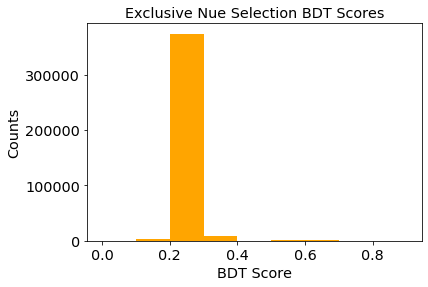

In [63]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [64]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
#if lepton mom (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)

In [65]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
#ENERGY
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
#ANGLE
NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0'
NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0'
#LEPTON MOM
#NUE_SEL_QUERY += ' and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5'
#NUE_SEL_QUERY += ' and targetP_asmuon > 0.04 & targetP_asmuon < 5'

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

#ending = "Sept19"

In [66]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [67]:
test = np.nansum(nue_dirt.query(SIGNAL_NUE_SEL_QUERY )['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_dirt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 0.0


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_dirt
--------------------------------------
current sample is:  nue_dirt
Had to return early (colour sorting).
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_n

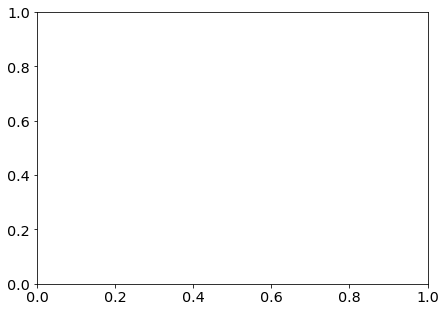

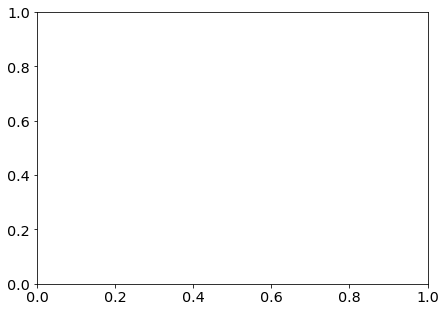

In [68]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # This is the POT scaling factor for dirt sample
        dirtratio = pot/1.42143e+21
        # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45

    # NU
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= BDT_LOOSE_CUTS,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


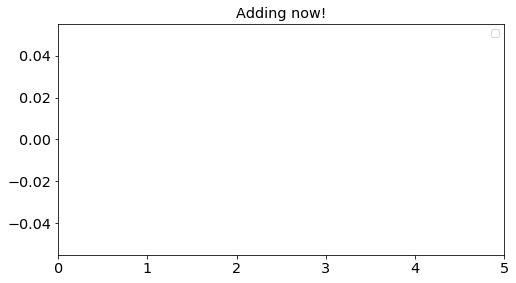

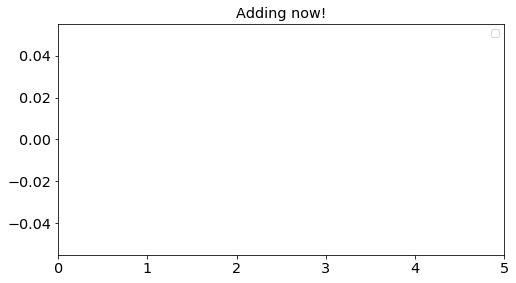

In [69]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [70]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


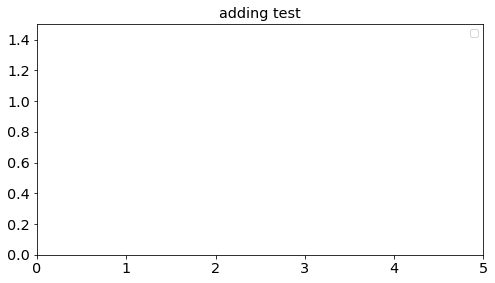

In [71]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 1.5])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.05])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [72]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [73]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Err

In [74]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # This is the POT scaling factor for dirt sample
        dirtratio = pot/1.42143e+21
        # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  nue_dirt

LOOK HERE FOR DETSYS
None
err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 an

In [75]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_dirt_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [76]:
if isRun3 == False:
    """
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """


    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """

    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errs

In [77]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


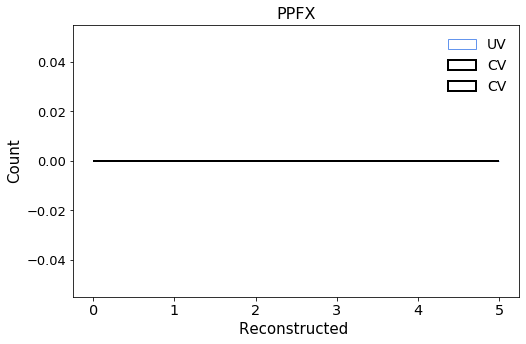

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


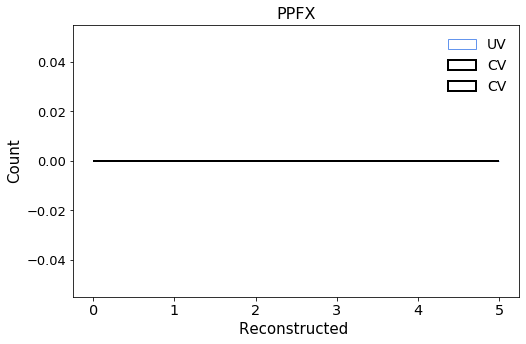

In [78]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    #bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    #bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [79]:
#will need to edit this if batching

nue_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [80]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [81]:
if isRun3 == False:
    """
    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """

    
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')
    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')
    
    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """

    
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


In [82]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


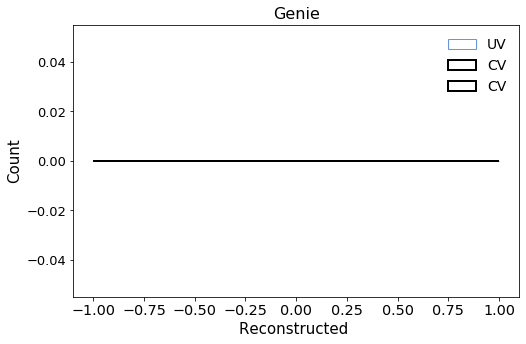

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


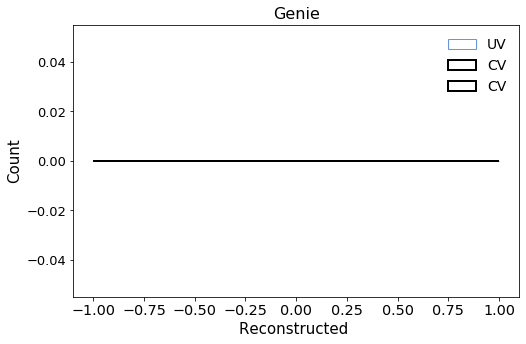

In [83]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [84]:
#will need to edit this if batching

nue_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [85]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_genie.append(sum(masterlist[a]))

final_ncvs_nue_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


Empty DataFrame
Columns: []
Index: []
Series([], Name: cosNu_Angle_Numi_Elec_asmuon_reco, dtype: float64)
Series([], Name: weightSpline, dtype: float32)


In [86]:
if isRun3 == False:
    """
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


In [87]:
########### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0
weightsReint
1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=rec

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


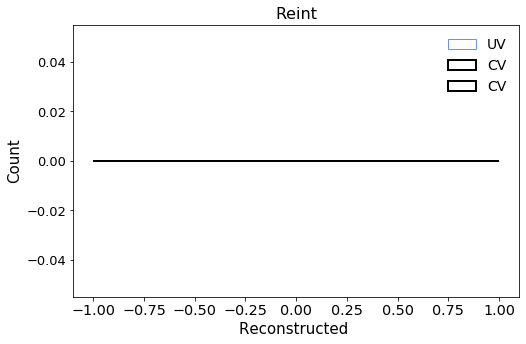

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


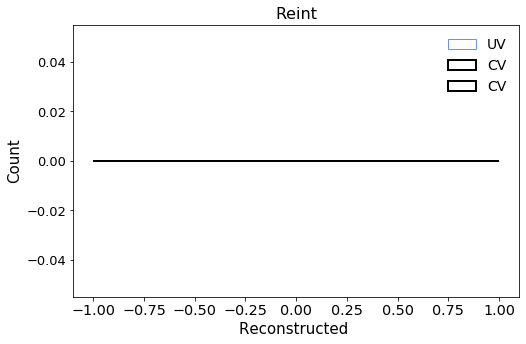

In [88]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [89]:
#will need to edit this if batching

nue_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [90]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_reint.append(sum(masterlist[a]))

final_ncvs_nue_dirt_reint = sum(n_cv_tots)
print(final_ncvs_nue_dirt_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Empty DataFrame
Columns: []
Index: []
Series([], Name: cosNu_Angle_Numi_Elec_asmuon_reco, dtype: float64)
Series([], Name: weightSplineTimesTuneTimesPPFX, dtype: float32)


In [91]:
if isRun3 == False:
    """
    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """

    
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [92]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0
1.0
2
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and cosNu_Angle_Numi_Elec_asmuon >-1.0 and cosNu_Angle_Numi_Elec_asmuon <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contai

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


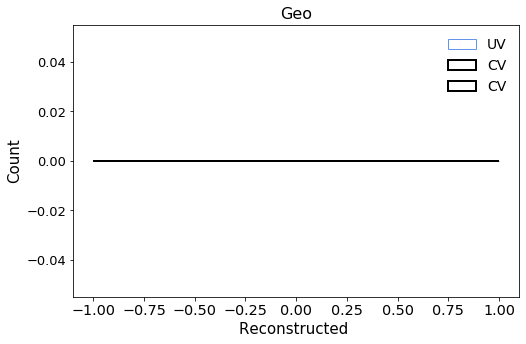

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


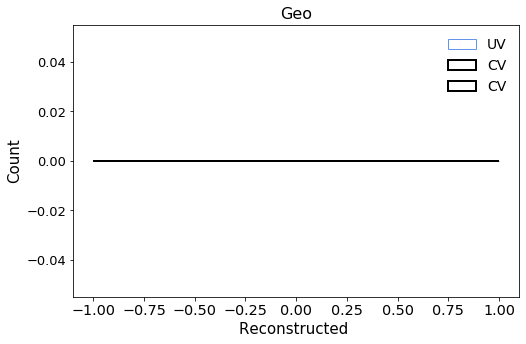

In [93]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [94]:
#will need to edit this if batching

nue_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [95]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_geo.append(sum(masterlist[a]))

final_ncvs_nue_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_dirt_geo)):
    final_ns_nue_dirt_geo[x] = np.concatenate((final_ns_nue_dirt_geo[x][0], final_ns_nue_dirt_geo[x][1]))
    
    
print(final_ns_nue_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
print(total_geo_df_splines)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Series([], Name: weightSplineTimesTuneTimesPPFX, dtype: float32)


In [96]:
if isRun3 == False:
    """
    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


## NUE_EXT SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
if isRun3 == False:
    EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
elif isRun3 == True:
    EXT  = '/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND    

#actually fetch datasets
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_ext]

nue_variables = ["run", "sub", "evt", "swtrig_pre",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_ext  = nue_ext.pandas.df(nue_variables + nue_varMC, flatten=False)

['slnhits', 'shr_energy_tot_cali', 'trk_energy_tot', 'slnunhits', 'shr_tkfit_nhits_V', 'hits_ratio', 'shr_tkfit_npoints', 'elec_e', 'shrmoliereavg', 'nproton', 'reco_nu_vtx_sce_x', 'shr_tkfit_nhits_Y', 'shr_tkfit_dedx_V', 'shrsubclusters1', 'sub', 'nslice', 'n_tracks', 'nu_pdg', 'shr_px', 'npion', 'shr_theta', 'shr_distance', 'tksh_distance', 'shr_pz', 'npi0', 'proton_e', 'shr_tkfit_nhits_U', 'n_showers', 'run', 'trk_energy', 'shr_energy_cali', 'shr_tkfit_dedx_Y', 'trkshrhitdist2', 'trk_score_v', 'category', 'shrsubclusters2', 'shr_phi', 'contained_fraction', 'shrsubclusters0', 'reco_nu_vtx_sce_z', 'shr_py', 'topological_score', 'swtrig_pre', 'reco_nu_vtx_sce_y', 'shr_tkfit_dedx_U', 'CosmicIPAll3D', 'evt', 'ccnc', 'shr_score', 'selected', 'n_showers_contained', 'shr_energy', 'flash_time', 'n_tracks_contained', 'tksh_angle']


In [6]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)
df_v = [nue_ext]


if isRun3 == False:
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
elif isRun3 == True:
    extratio  = 10363728.0/32878305.25
    scalingEXT = 0.98


nue_ext['pot_scale'] = extratio * scalingEXT

In [7]:
nue_ext['totweight_data'] = nue_ext['pot_scale']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_ext]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    #puppa_shw = []
    #puppa_prt = [] 
    #puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        #N_recoShowers = 0
        #N_recoProtons = 0
        #N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            #protonCut  = (passPIDCut & passTrkCut) 
            #muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            #N_obj         = len(passTrkCut)
            #N_recoTrks    = np.count_nonzero(passTrkCut)
            #N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            #N_recoProtons = np.count_nonzero(protonCut)
            #N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        #puppa_shw.append(N_recoShowers)    
        #puppa_prt.append(N_recoProtons)
        #puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    #df['N_recoShowers']   = puppa_shw
    #df['N_recoProtons']   = puppa_prt
    #df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    #df['protonenergy']    = trk_energy_proton_sel
    #df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    #df['protontheta']  = trk_theta_proton_sel
    #df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
#for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
#    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  83.54100346565247


In [11]:
nue_ext.query("swtrig_pre==1 and nslice==1 and contained_fraction>0.9 \
and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04", inplace=True)

In [12]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
df_v = [nue_ext]
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.42975330352783203


In [13]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        if (len(df["mc_pdg"].iloc[j]) !=0):
            pdg_vector = df["mc_pdg"].iloc[j][0]
            px_vector = df["mc_px"].iloc[j]
            py_vector = df["mc_py"].iloc[j]
            pz_vector = df["mc_pz"].iloc[j]
            result = np.where(pdg_vector==11)[0]
            if np.size(result):
                df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
                df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
                df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]

    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
233       NaN
392       NaN
438       NaN
602       NaN
1004      NaN
           ..
3209925   NaN
3210004   NaN
3210354   NaN
3210856   NaN
3210936   NaN
Name: elec_px_asmuon, Length: 11839, dtype: float64
time to run:  0.053653717041015625


In [14]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [15]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [16]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [17]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_ext]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    #df["extdata"] = np.zeros_like(df["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])

In [119]:
#for i,df in enumerate(df_v):

#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [120]:
# add back the cosmic category, for background only
#df_v = [nue_ext]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [18]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT 

In [122]:
#Define signal catagories

#nue_ext["is_signal"] = nue_ext["category"] == 11

Set up complete. Set up BDT for selection.

In [19]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [20]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})

if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')    

In [21]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_ext]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(11839, 101)


In [22]:
datasets_bdt = nue_ext

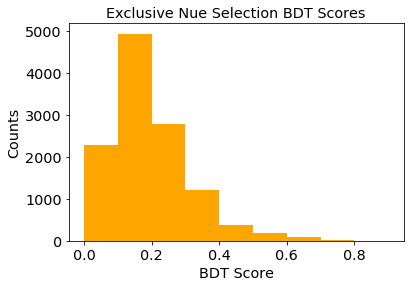

In [23]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [36]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
#if lepton mom (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)

In [39]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
#ENERGY
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#ANGLE
NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0'
#LEPTON MOM
#NUE_SEL_QUERY += ' and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5'

#No true selection here as this is data

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [40]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.swtrig_pre==1)&(df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [41]:
test = np.nansum(nue_ext.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_ext.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 4.324746883357073


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  11839
n_events/2 here =  5919.0

1.0
1
{'ext': 0.3089104916683624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_ext
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 4.324746883357073
current_total  0.0
0.00000000000000000000000000000000000000000

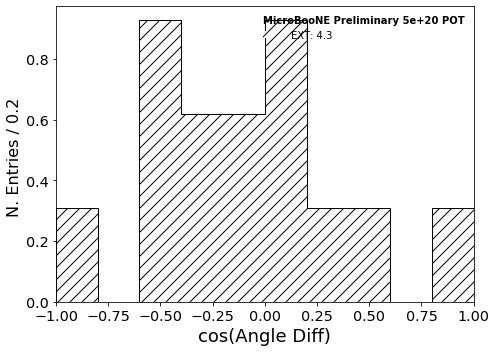

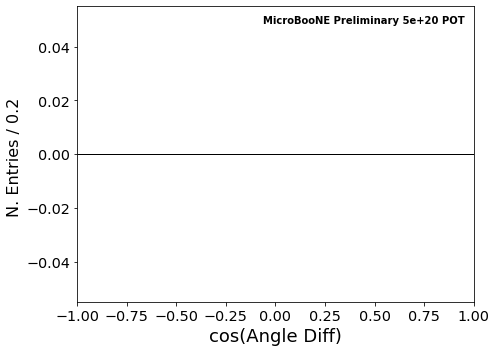

In [42]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
#batch_size = n_events
batch_size = n_events
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_ext.iloc[start:end]

    samples = {
        "nue_ext": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
        extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
        # We scale down the EXT to account for neutrino occupancy
        scalingEXT = 0.98
    elif isRun3 == True:
        pot =  5e+20
        extratio  = 10363728.0/32878305.25
        scalingEXT = 0.98
    

    # NU
    weights = { #full sample mc = 0.38  
                "ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


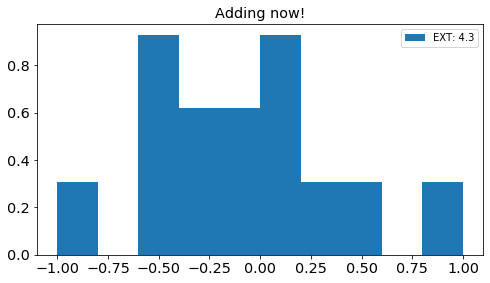

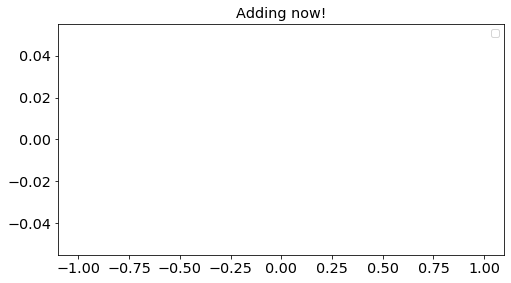

In [43]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [44]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

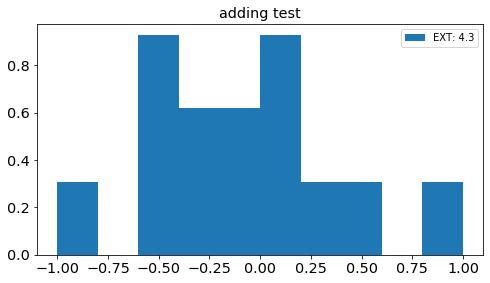

In [45]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = labss


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 4])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.8])

nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [46]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [47]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Errs

[0.55579717 0.         0.96266893 0.78601589 0.78601589 0.96266893
 0.55579717 0.55579717 0.         0.55579717]


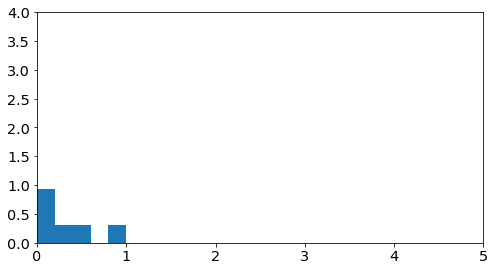

In [48]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 4])


nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


nue_ext_stat_errs = np.sqrt(nue_stacked[0])

print(nue_ext_stat_errs)

In [49]:
if isRun3 == False:
    """
    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_ext_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
    #           nue_ext_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
    #           nue_nue_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
    #           nue_nue_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_ext_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_07Jul.csv", 
    #           nue_ext_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')
    """

    
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
    #           nue_nue_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')
    
    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
    #           nue_nue_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')
    """
        

## NUE_DATA SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
if isRun3 == False:
    BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
elif isRun3 == True:
    BNB  = '/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND    

#actually fetch datasets
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_data]

nue_variables = ["run", "sub", "evt", "swtrig_pre",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_data = nue_data.pandas.df(nue_variables + nue_varMC , flatten=False)

['shr_tkfit_nhits_Y', 'contained_fraction', 'shrsubclusters1', 'flash_time', 'slnunhits', 'shr_tkfit_dedx_V', 'trk_energy_tot', 'nproton', 'shr_tkfit_nhits_V', 'trk_energy', 'trkshrhitdist2', 'reco_nu_vtx_sce_z', 'topological_score', 'shr_energy', 'shrsubclusters2', 'shr_energy_tot_cali', 'shr_tkfit_nhits_U', 'shr_phi', 'tksh_angle', 'shr_distance', 'shrmoliereavg', 'npion', 'reco_nu_vtx_sce_y', 'n_tracks_contained', 'shr_score', 'shr_theta', 'elec_e', 'shr_pz', 'swtrig_pre', 'n_tracks', 'proton_e', 'n_showers_contained', 'sub', 'tksh_distance', 'shr_tkfit_npoints', 'nu_pdg', 'selected', 'CosmicIPAll3D', 'hits_ratio', 'nslice', 'shr_tkfit_dedx_U', 'shrsubclusters0', 'trk_score_v', 'shr_px', 'reco_nu_vtx_sce_x', 'category', 'run', 'evt', 'shr_tkfit_dedx_Y', 'slnhits', 'npi0', 'ccnc', 'shr_energy_cali', 'n_showers', 'shr_py']


In [6]:
nue_data['pot_scale'] = [1 for x in range(len(nue_data))]

In [7]:
nue_data['totweight_data'] = nue_data['pot_scale']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
df_v = [nue_data]

import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  40.628965854644775


In [11]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        if (len(df["mc_pdg"].iloc[j]) !=0):
            pdg_vector = df["mc_pdg"].iloc[j][0]
            px_vector = df["mc_px"].iloc[j]
            py_vector = df["mc_py"].iloc[j]
            pz_vector = df["mc_pz"].iloc[j]
            result = np.where(pdg_vector==11)[0]
            if np.size(result):
                df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
                df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
                df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]

    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1104344   NaN
1104345   NaN
1104346   NaN
1104347   NaN
1104348   NaN
Name: elec_px_asmuon, Length: 1104349, dtype: float64
time to run:  4.320251941680908


In [12]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [13]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_data]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  89.22739672660828


In [14]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [15]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [16]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_data]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"]+ df["proton_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    #df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])


In [17]:
#for i,df in enumerate(df_v):

#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [18]:
# add back the cosmic category, for background only
#df_v = [nue_data]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [19]:
#Define signal catagories

#nue_data["is_signal"] = nue_data["category"] == 11

Set up complete. Now on to BDT.

In [20]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [21]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})

if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')
    

In [22]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(1104349, 107)


In [23]:
datasets_bdt = nue_data

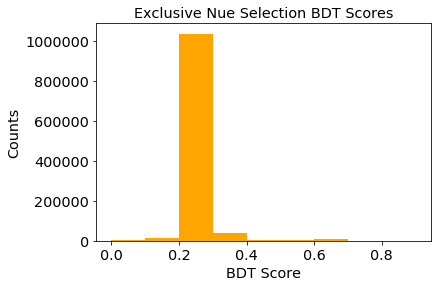

In [24]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [34]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) &  (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
#if lepton mom (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)

In [35]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
#ENERGY
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#ANGLE
NUE_SEL_QUERY += ' and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0'
#LEPTON MOM
#NUE_SEL_QUERY += ' and targetP_asmuon_reco > 0.04 & targetP_asmuon_reco < 5'
#No truth selection as this data

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [36]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [37]:
test = np.nansum(nue_data.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_data.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0
total signal events = 163


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  1104349
n_events/2 here =  552174.0

1.0
1
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0 and BDT_score > 0.575 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_data
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
----------------------

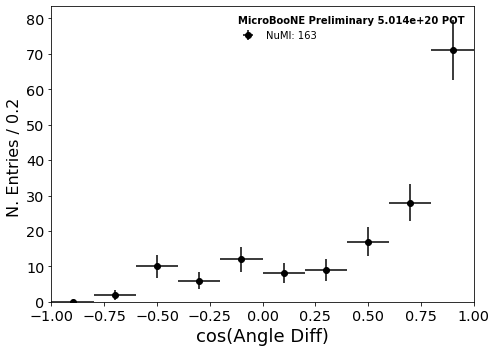

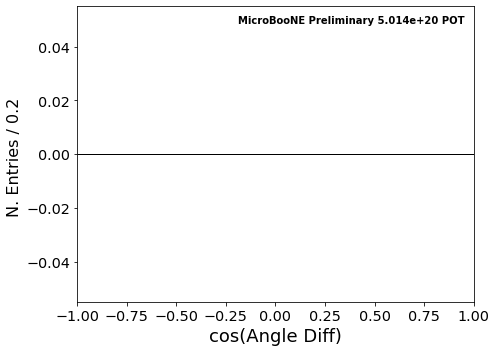

In [38]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_data.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_data.iloc[start:end]

    samples = {
        "nue_data": sample_set 
    }

    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 
    elif isRun3 == True:
        pot =  5.014e+20 
        
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

[array([ 0,  2, 10,  6, 12,  8,  9, 17, 28, 71]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


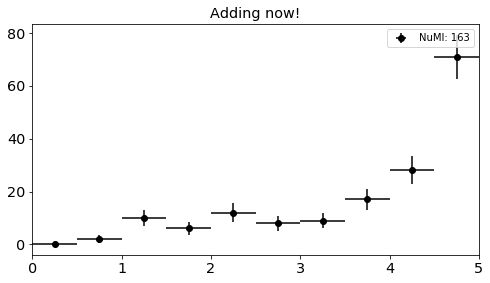

In [39]:
from matplotlib import gridspec

#for i in range(int(n_events/batch_size)+1):
for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    current_bincenters =  np.arange(0.25, 5.25, 0.5)
    current_bin_size = 0.5
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    
    print(varss)
    
    nue_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [40]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[0.         1.41421356 3.16227766 2.44948974 3.46410162 2.82842712
 3.         4.12310563 5.29150262 8.42614977]


[ 0  2 10  6 12  8  9 17 28 71]


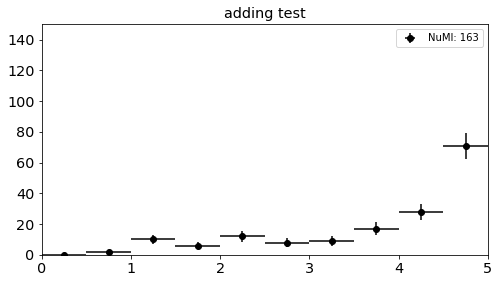

In [41]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = labss

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 150])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 33])

print(varss_tot)

nue_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [42]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    

## NUMU_MC SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
elif isRun3 == True:
    NU   = '/neutrinoselection_filt_run3b_overlay'    +ls.APPEND   

#actually fetch datasets
numu_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_mc]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", #"trk_pfp_id",
        "category", "ccnc", "swtrig_pre", "trk_len_v",
        "run","sub","evt", "hits_ratio",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance", "n_tracks_contained",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['category', 'n_showers_contained', 'nproton', 'tksh_distance', 'trk_len_v', 'backtracked_pdg', 'npion', 'reco_nu_vtx_z', 'isVtxInFiducial', 'trk_sce_end_y_v', 'nslice', 'trk_energy_muon', 'trk_sce_end_x_v', 'evnunhits', 'trk_llr_pid_score_v', 'sub', 'hits_ratio', 'slnhits', 'shr_energy_tot_cali', '_opfilter_pe_veto', 'mc_pdg', 'trk_phi', 'trk_range_muon_mom_v', 'true_e_visible', 'trk_score_v', 'CosmicIPAll3D', 'pi0truth_elec_etot', 'reco_nu_vtx_x', 'CosmicIP', 'reco_e', 'n_tracks_contained', 'evt', '_opfilter_pe_beam', 'nmuon', 'trk_theta', 'proton_e', 'swtrig_pre', 'trk_mcs_muon_mom_v', 'nu_pdg', 'reco_nu_vtx_sce_y', 'slnunhits', 'ccnc', 'reco_nu_vtx_y', 'reco_nu_vtx_sce_z', 'muon_e', 'CosmicDirAll3D', 'shr_tkfit_dedx_Y', 'trk_energy_tot', 'npi0', 'interaction', 'pi0_e', 'elec_e', 'slpdg', 'flash_pe', 'reco_nu_vtx_sce_x', 'run', 'pion_e', 'topological_score', 'contained_fraction', 'trk_sce_end_z_v', 'slclustfrac', 'trk_sce_start_x_v']


In [6]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#approx 25 min run time

trk_llr_pid_v  [[0.9051982] [] [] ... [] [] [0.96284807]]
trk_score_v  [[0.9768751] [] [] ... [] [] [1.0]]
Here:
trk_range_muon_mom_v  [[0.25889522] [] [] ... [] [] [0.5288412]]
trk_mcs_muon_mom_v  [[0.47899732] [] [] ... [] [] [0.46399802]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  1256.016586780548


In [7]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:
#numu_mc.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and \
#reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and \
#n_muons_tot > 0 and n_showers_contained==0", inplace=True)
numu_mc.query("nu_e > 0 and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score > 0.3", inplace=True)
#numu_mc.query("nu_e > 0", inplace=True)

In [10]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 
#Run3 = 

runtime =  4.910242080688477


In [11]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']
    #print(df['trk_sce_start_x_v'])
    #print(df['reco_nu_vtx_sce_x'])
    #print(df['nu_pdg'])

In [12]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [13]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33652E21
elif isRun3 == True:
    beamon_pot = 5.014E20
    overlay_pot =  1.98937e+21    

numu_mc['pot_scale'] = beamon_pot/overlay_pot

In [14]:
numu_mc['totweight_data'] = numu_mc['pot_scale']*numu_mc['weightSplineTimesTuneTimesPPFX']
print(numu_mc['totweight_data'])

entry
139       3.166345e-15
172       2.671849e-01
334       1.859608e-01
588       3.127460e-01
600       1.764178e-01
              ...     
748203    5.742949e-10
748266    2.006112e-01
748390    2.712178e-01
748418    7.541192e-02
748482    2.708204e-01
Name: totweight_data, Length: 5751, dtype: float64


In [15]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [16]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5146/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  23.576395273208618


In [17]:
#numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

In [17]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [18]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [37]:
#df_v = [numu_mc]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    print(df['trk_mcs_muon_mom_v'])

In [17]:
#The selection query
#numu_mc.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 n_showers_contained==1 and shr_tkfit_dedx_Y<4 and tksh_distance<5", inplace=True)

In [19]:
#RECO VARIABLE

s = time.time()
df_v = [numu_mc]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    print(df['muon_momentum'])

#if track is stopped in fiducial volume
#    then use stoppingmom
#else
#    use other mom
    
#set up this new variable for each one in  the dataframe

#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)

entry
139       0.412328
172       0.367986
334       0.192586
588       0.220205
600       0.326574
            ...   
748203    0.414276
748266    0.459054
748390    0.179733
748418     0.56973
748482    0.267991
Name: muon_mom, Length: 5751, dtype: object

runetime =  14.719194173812866


In [20]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [21]:
print(df['cosNu_Angle_Numi_Muon_Reco'])

entry
139       0.912541
172       0.000652
334       0.994987
588      -0.016814
600       0.896793
            ...   
748203    0.438212
748266    0.310292
748390   -0.638122
748418    0.861851
748482    0.611704
Name: cosNu_Angle_Numi_Muon_Reco, Length: 5751, dtype: float64


In [22]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)
#R1 approx 22 mins
#R3 approx 10 mins


runetime =  14.953638553619385


In [23]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [24]:
numu_mc   = numu_mc.query('nu_e > 0.')
#numu_mc.query("nu_e > 0.", inplace=True)

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete. 

In [25]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(numu_mc.query(nueCC_query))))
len1 = len(numu_mc)

idx = numu_mc.query(nueCC_query).index
numu_mc.drop(idx, inplace=True)
len2 = len(numu_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))

# of nueCC in AV in overlay sample = 9
# of nueCC in AV dropped in overlay = 9


In [26]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

#numu_nue   = numu_mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "numu_mc"  : numu_mc
}


if isRun3 == False:
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
elif isRun3 == True:
    pot =  5.014e20
    mcratio  = pot/1.98937e+21
        
#nueratio  = pot/2.37838e+22

SPLIT = 1.0
scaling = 1

weights = { "numu_mc"  : mcratio  * SPLIT * scaling  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_mc': 0.25203959042309876}


In [78]:
dfmc_v = [numu_mc]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
#if lepton momemtum add (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)

In [79]:
#New categories

for i,df in enumerate(dfmc_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)&  (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    #df["numu_CCother_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0==0), True, False)
    #df.loc[ (df['numu_CCother_0pi0']== True), 'category' ] = 9
    #df["numu_CCother_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0>0), True, False)
    #df.loc[ (df['numu_CCother_Npi0']== True), 'category' ] = 31
    #df["numu_CCother_0pi00p"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0==0)& (df.npion>0), True, False)
    #df.loc[ (df['numu_CCother_0pi00p']== True), 'category' ] = 21
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False), True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [29]:
#####temp categpries########
"""
dfmc_v = [numu_mc, numu_nue]

for i,df in enumerate(dfmc_v):
    
    print(df.mc_pdg)

    df['muon'] = np.where(df.mc_pdg==13, True, False)
    df.loc[ (df['muon']== True), 'category' ] = 1
    
    df['proton'] = np.where(df.mc_pdg==2212, True, False)
    df.loc[ (df['proton']== True), 'category' ] = 2
    
    df['other'] = np.where(df.mc_pdg!=13 and df.mc_pdg!=2212, True, False)
    df.loc[ (df['other']== True), 'category' ] = 3
"""

"\ndfmc_v = [numu_mc, numu_nue]\n\nfor i,df in enumerate(dfmc_v):\n    \n    print(df.mc_pdg)\n\n    df['muon'] = np.where(df.mc_pdg==13, True, False)\n    df.loc[ (df['muon']== True), 'category' ] = 1\n    \n    df['proton'] = np.where(df.mc_pdg==2212, True, False)\n    df.loc[ (df['proton']== True), 'category' ] = 2\n    \n    df['other'] = np.where(df.mc_pdg!=13 and df.mc_pdg!=2212, True, False)\n    df.loc[ (df['other']== True), 'category' ] = 3\n"

In [80]:
"""
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010  \
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score > 0.3"
#ENERGY
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
#ANGLE
#NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0'
#NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0'
#LEPTON MOM
NUMU_SEL_QUERY += ' and muon_mom > 0.04 & muon_mom < 5'
NUMU_SEL_QUERY += ' and targetP > 0.04 & targetP < 5'

#ending = "Sept19_03"

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += ' and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += ' and is_signal==False'

In [81]:
test_total = np.nansum(numu_mc.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test_total))
test = np.nansum(numu_mc.query(NUMU_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0 & -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8)")['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 1465.5745430524842
total signal events = 1465.5745430524842


In [82]:
test_signal = np.nansum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test_signal))
test = np.nansum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 1056.9041105248984
total signal events = 1056.9041105248984


In [83]:
test = np.nansum(numu_mc.query(NOT_SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 408.6704325275859


In [84]:
print(test_signal/test_total)

0.7211534312840813


Now plot.

n_events here =  5742

1.0
1
{'numu_mc': 1}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and muon_mom > 0.04 & muon_mom < 5 and targetP > 0.04 & targetP < 5& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  1465.5745430524842
1465.574543052484159488813020288944244384765625000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1465.5745430524842
1465.57454305248415948881302028894424438476

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


current_total_hist  [1.05443415e+03 3.55566699e+02 4.57821451e+01 8.38305685e+00
 1.06676555e+00 0.00000000e+00 3.41730548e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1465.5745430524855

Returning
{'numu_mc': 1}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and muon_mom > 0.04 & muon_mom < 5 and targetP > 0.04 & targetP < 5& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
Had to return early (colour sorting).


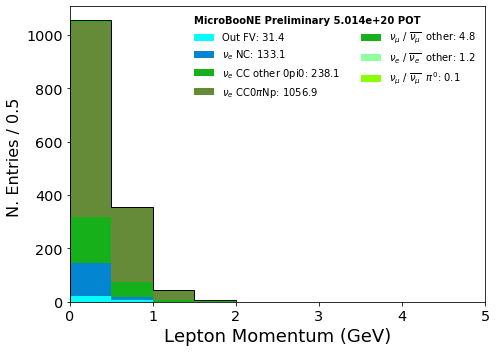

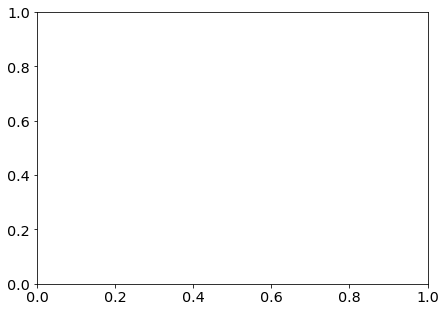

In [85]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }

    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21


    # NUMU
    weights = { #full sample mc = 0.38
                #"numu_mc"  : mcratio  * SPLIT * scaling
                "numu_mc"  : 1
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.3, 0.8),"Topological Score"
    #VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',10,(0, 10),"Topological Score"
    #VARIABLE, BINS, RANGE, XTIT = 'hits_ratio',10,(0, 10),"Topological Score"
    #VARIABLE, BINS, RANGE, XTIT = 'trk_llr_pid_score_v',40,(-1.0, 1.0),"LLR PID Score"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',9,(0.0, 225.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',8,(-100.0, 100.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',10,(100.0, 800.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query="",
        currentsample = "numu_mc",
        kind="event_category",
        #kind="particle_pdg",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        #genieweight = "weightSplineTimesTuneTimesPPFX", 
        genieweight = "totweight_data", 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  5742

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and muon_mom > 0.04 & muon_mom < 5 and targetP > 0.04 & targetP < 5 and is_signal==True& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  1056.9041105248982
1056.904110524898214862332679331302642822265625000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1056.9041105248982
1056.

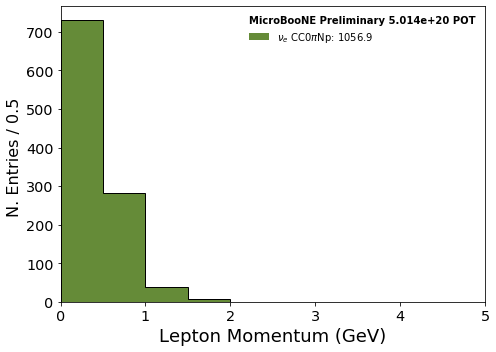

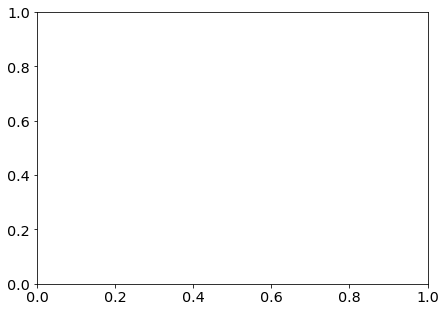

In [91]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUMU_SEL_QUERY,
        #query= "is_signal == True",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


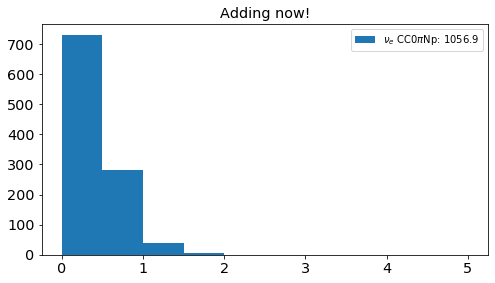

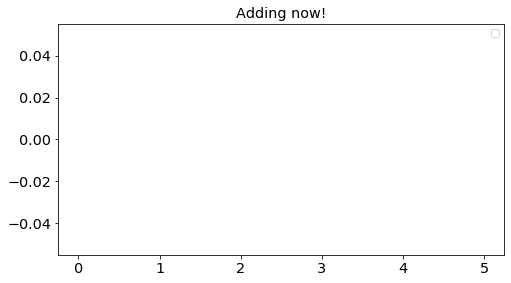

In [92]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-20, 280])    #Vtx X
    #numu_ax1.set_xlim([-140, 140])    #Vtx Y
    #numu_ax1.set_xlim([-10, 1100])    #Vtx Z
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [93]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

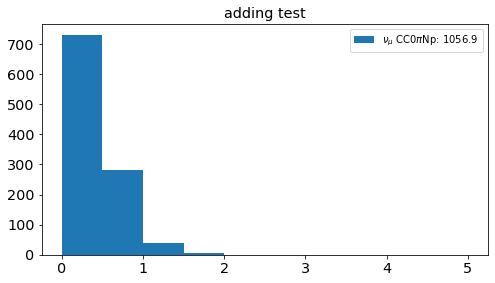

In [94]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_xlim([-20, 280])
#numu_ax1.set_xlim([-140, 140])
#numu_ax1.set_xlim([-10, 1100])
#numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [95]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 3  #3

numu_wanted_list = numu_stacked[0]
#numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[7.29575231e+02 2.82643046e+02 3.77793066e+01 6.58780522e+00
 3.18721434e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [96]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True

if isRun3 == False:
    if (is_selected == True):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
elif isRun3 == True:
    if (is_selected == True):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_run3_'+ending+'.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_run3_'+ending+'.csv')
        ########leptonMom
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')
        

### Stat Errors

In [47]:
####NUMU####

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { 
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  5742

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 and is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[ 5.59010805  5.33601223  7.30525484  8.6392579  10.41792864 14.54698573
 19.37480632 28.90339959 51.77202344 79.21437206]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

se

In [48]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [5.590108052376617, 5.336012231814044, 7.305254841173988, 8.639257899127498, 10.417928643065514, 14.546985727207332, 19.37480631789623, 28.903399588992738, 51.77202343962435, 79.21437206038229]
total selected =  [21.625934600830078, 21.935718536376953, 31.385658264160156, 37.19339370727539, 40.55247116088867, 65.65054321289062, 84.48666381835938, 125.1180191040039, 233.1294403076172, 395.82623291015625]


In [49]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    """
    
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

In [50]:
###NUMU NOT SIGNAL####

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NOT_SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  5742

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 and is_signal==False 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[ 3.04914985  2.4139103   1.96924261  1.8421947   2.47743425  4.25610499
  6.98763507 12.45069521 26.04482161 51.89907135]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

s

In [51]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [3.049149846750882, 2.4139102953444485, 1.9692426093599447, 1.842194699078658, 2.4774342504850915, 4.256104994423106, 6.987635065470771, 12.4506952075661, 26.04482160766378, 51.89907134990564]
total selected =  [10.756797790527344, 8.323746681213379, 7.1436543464660645, 6.147030830383301, 9.144172668457031, 14.568707466125488, 25.91816520690918, 43.19344711303711, 94.83091735839844, 190.19381713867188]


In [52]:
if isRun3 == False:  
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:  
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')
               
    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [53]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5742

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1448   537  1108  1263    12   464  1239  1321   710   834  ...  1566   
1      791  1013   878   744  1129   979   623  1339  1078   586  ...  1209

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 32.38273239  30.25946426  38.52931213  43.34042358  49.69664001
  80.21925354 110.40481567 168.3114624  327.96038818 586.02001953]


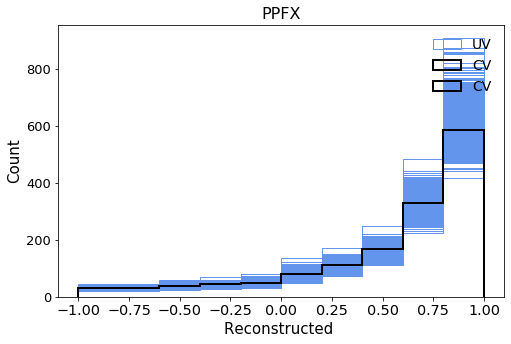

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


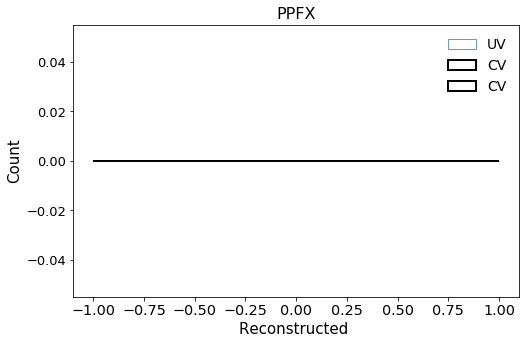

In [54]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)


    plt.show()

In [55]:
#will need to edit this if batching

numu_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [56]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [57]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
if isRun3 == True:
    """
    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [58]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5742

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        1     0     0     0     1     0     1     1     1     1  ...     1

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 32.38273239  30.25946426  38.52931213  43.34042358  49.69664001
  80.21925354 110.40481567 168.3114624  327.96038818 586.02001953]


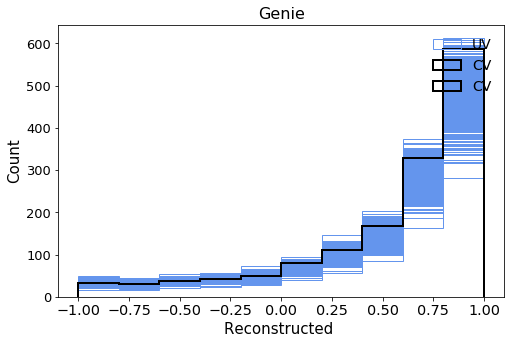

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


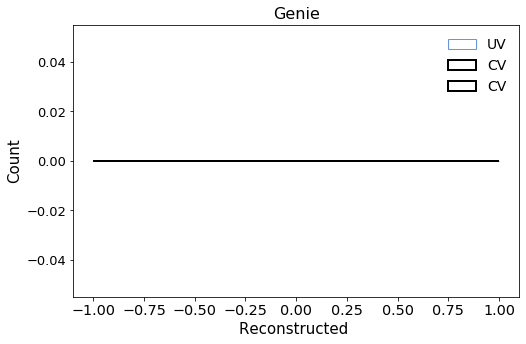

In [59]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [60]:
#will need to edit this if batching

numu_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [61]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [62]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
if isRun3 == True:
    """
    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [63]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5742

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0      976   928  1049  1002   965   985   973   981  1030   986  ...   958   
1      900   704  1283  1009   866   929   843   916  1122   951  ...   799

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 32.38273239  30.25946426  38.52931213  43.34042358  49.69664001
  80.21925354 110.40481567 168.3114624  327.96038818 586.02001953]


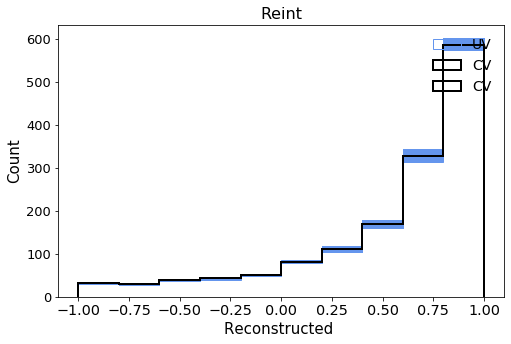

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


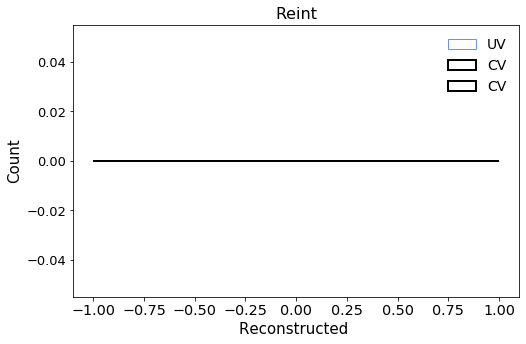

In [64]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [65]:
#will need to edit this if batching

numu_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [66]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [67]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #############################
    #####angleDiff##########
    #######################
    
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #############################
    #####leptonMom##########
    #######################
    
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #############################
    #####angleDiff##########
    #######################
    
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #############################
    #####leptonMom##########
    #######################
    
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


In [68]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5742
1.0
2
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vt

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[ 32.38273239  30.25946426  38.52931213  43.34042358  49.69664001
  80.21925354 110.40481567 168.3114624  327.96038818 586.02001953]


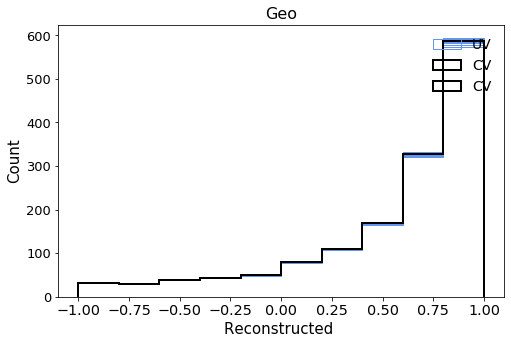

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


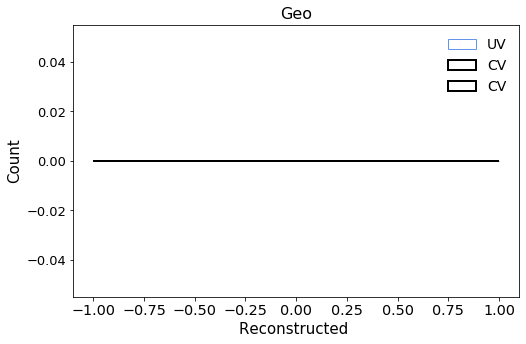

In [69]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [70]:
#will need to edit this if batching

numu_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [71]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [72]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    ########################
    ####angleDiff##########
    #######################
    

    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    ########################
    ####angleDiff##########
    #######################
    

    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


## NUMU_NUE SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE   = '/neutrinoselection_filt_run1_overlay_intrinsic'    +ls.APPEND #newTune
elif isRun3 == True:
    NUE   = '/neutrinoselection_filt_run3b_overlay_intrinsic'    +ls.APPEND   

#actually fetch datasets
numu_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_nue]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", #"trk_pfp_id",
        "category", "ccnc", "swtrig_pre", "trk_len_v",
        "run","sub","evt", "hits_ratio",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance", "n_tracks_contained",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['true_e_visible', 'n_showers_contained', 'sub', 'nmuon', 'tksh_distance', 'reco_nu_vtx_x', 'isVtxInFiducial', 'reco_e', 'trk_range_muon_mom_v', 'nslice', 'contained_fraction', '_opfilter_pe_veto', 'shr_energy_tot_cali', 'proton_e', 'nu_pdg', 'reco_nu_vtx_sce_y', 'backtracked_pdg', 'pi0truth_elec_etot', 'nproton', 'trk_energy_tot', 'muon_e', 'pion_e', 'interaction', 'trk_energy_muon', 'shr_tkfit_dedx_Y', 'evt', '_opfilter_pe_beam', 'reco_nu_vtx_sce_x', 'slclustfrac', 'trk_sce_start_x_v', 'trk_phi', 'mc_pdg', 'slnhits', 'CosmicIPAll3D', 'trk_sce_end_y_v', 'trk_mcs_muon_mom_v', 'CosmicIP', 'npi0', 'run', 'hits_ratio', 'reco_nu_vtx_z', 'slnunhits', 'trk_len_v', 'CosmicDirAll3D', 'swtrig_pre', 'elec_e', 'reco_nu_vtx_sce_z', 'pi0_e', 'topological_score', 'trk_llr_pid_score_v', 'evnunhits', 'trk_sce_end_x_v', 'trk_sce_end_z_v', 'trk_theta', 'n_tracks_contained', 'ccnc', 'flash_pe', 'npion', 'category', 'trk_score_v', 'reco_nu_vtx_y', 'slpdg']


In [6]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_nue] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_nue = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#approx 3 min run time

trk_llr_pid_v  [[0.9324786] [0.590139 0.9521533 0.3471874 ... 0.32588285 -0.09476762 0.10572114] [] ... [0.6322873 -0.80414367] [0.9089123 -0.7736061] []]
trk_score_v  [[0.001973996] [0.0077069523 0.9997616 0.8196208 ... 0.029083267 0.8604026 0.8221332] [] ... [0.012679829 0.9684213] [0.30360103 0.9360796] []]
Here:
trk_range_muon_mom_v  [[0.39945376] [0.29477474 0.35777104 0.10886712 ... 0.10216848 0.085918136 0.052376423] [] ... [0.15139814 0.17097917] [0.2588373 0.15329416] []]
trk_mcs_muon_mom_v  [[0.3239991] [0.20500024 0.34899905 0.10800004 ... 0.08299999 14.998431 14.998431] [] ... [0.106000036 0.68099475] [0.18200019 0.36699882] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  154.02050805091858


In [7]:
df_v = [numu_nue]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_nue]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:

numu_nue.query("nu_e > 0 and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0", inplace=True)
#numu_mc.query("nu_e > 0", inplace=True)

In [10]:
s = time.time()

df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 13 mins
#Run3 = 

runtime =  0.2632484436035156


In [11]:
df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [12]:
df_v = [numu_nue]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [13]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    intrinsic_pot =  2.37838E22
elif isRun3 == True:
    beamon_pot = 5.014E20
    intrinsic_pot =   2.5345e+22   

numu_nue['pot_scale'] = beamon_pot/intrinsic_pot

In [14]:
numu_nue['totweight_data'] = numu_nue['pot_scale']*numu_nue['weightSplineTimesTuneTimesPPFX']
print(numu_nue['totweight_data'])

entry
21        0.020693
613       0.010097
1452      0.022657
1746      0.024397
2211      0.009558
            ...   
123753    0.010743
123780    0.019552
123790    0.020038
123902    0.020616
123924    0.009042
Name: totweight_data, Length: 400, dtype: float64


In [15]:
df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [16]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

runtime =  1.5951919555664062


In [17]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [18]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [19]:
df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    print(df['trk_mcs_muon_mom_v'])

entry
21                     [0.74599445, 0.09300001, 0.12600008]
613                    [0.21200025, 0.34899905, 0.24800032]
1452                       [0.570996, 14.999432, 14.999432]
1746                               [0.33499923, 0.12200007]
2211                              [0.42199785, 0.110000044]
                                ...                        
123753    [0.8619925, 0.12600008, 0.71599436, 0.25400028...
123780                   [0.62999547, 0.24700032, 0.745994]
123790    [0.29699966, 0.4379979, 0.26500008, 14.999432,...
123902       [0.17900018, 0.7829953, 0.37699842, 0.2590002]
123924                               [0.15600014, 0.745994]
Name: trk_mcs_muon_mom_v, Length: 400, dtype: object


In [20]:
#RECO VARIABLE
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)


entry
21                         [927.7503, 777.48627, 768.25916]
613                        [449.10638, 429.06036, 437.3787]
1452                         [932.5985, 935.1153, 821.6419]
1746                                  [435.49133, 412.6605]
2211                                  [877.65076, 848.9412]
                                ...                        
123753    [178.6571, 153.41556, 157.90085, 143.6084, 152...
123780                       [312.5676, 317.47983, 294.509]
123790    [251.26093, 124.37225, 110.46726, 91.18728, 90...
123902          [988.60895, 965.48956, 905.74304, 864.5555]
123924                               [365.57162, 356.34222]
Name: trk_sce_end_z_v, Length: 400, dtype: object
entry
21          0.6633
613       0.252832
1452      0.416117
1746      0.253437
2211      0.416197
            ...   
123753    0.181204
123780    0.238133
123790    0.591585
123902    0.328489
123924    0.184916
Name: muon_mom, Length: 400, dtype: object

runetime =  0.77586388587

In [21]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [22]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)


runetime =  0.3442981243133545


In [23]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [24]:
numu_nue   = numu_nue.query('nu_e > 0.')
#numu_mc.query("nu_e > 0.", inplace=True)

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Setup complete.

In [25]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_nue" : numu_nue
}


if isRun3 == False:
    pot =  2e+20 
    nueratio  = pot/2.37838e+22 
elif isRun3 == True:
    pot =  5.014e20
    nueratio  = pot/2.5345e+22


SPLIT = 1.0
scaling = 1

weights = { 
            "numu_nue"  : nueratio  * SPLIT * scaling   
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_nue': 0.01978299467350562}


In [58]:
dfmc_v = [numu_nue]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
#if lepton momemtum add (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)

In [59]:
#New categories

for i,df in enumerate(dfmc_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)&  (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    #df["numu_CCother_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0==0), True, False)
    #df.loc[ (df['numu_CCother_0pi0']== True), 'category' ] = 9
    #df["numu_CCother_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0>0), True, False)
    #df.loc[ (df['numu_CCother_Npi0']== True), 'category' ] = 31
    #df["numu_CCother_0pi00p"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0==0)& (df.npion>0), True, False)
    #df.loc[ (df['numu_CCother_0pi00p']== True), 'category' ] = 21
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False), True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [60]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  \
and contained_fraction> 0.95 and topological_score > 0.3"
#ENERGY
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
#ANGLE
NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0'
NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0'
#LEPTON MOM
#NUMU_SEL_QUERY += ' and muon_mom > 0.04 & muon_mom < 5'
#NUMU_SEL_QUERY += ' and targetP > 0.04 & targetP < 5'


SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += ' and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += ' and is_signal==False'

In [61]:
test = np.nansum(numu_nue.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

test = np.nansum(numu_nue['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0.0
total signal events = 7.409802611154893


Now plot.

n_events here =  400

1.0
1
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_nue
--------------------------------------
current sample is:  numu_nue
Had to return early (colour sorting).
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_n

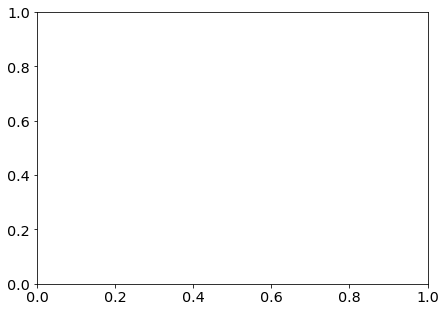

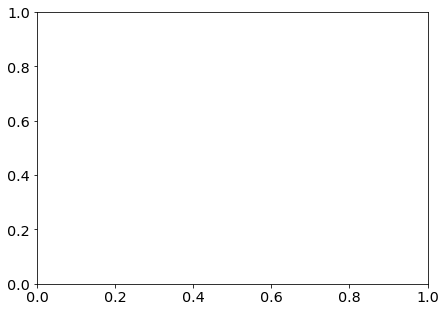

In [62]:
#The numu_nue plot 

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []
if n_events > 0:
    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = numu_nue.iloc[start:end]

        samples = {
            "numu_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            nueratio  = pot/2.37838e+22 
        elif isRun3 == True:
            pot =  5.014e20
            nueratio  = pot/2.5345e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "numu_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
        #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
        #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
        #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
        #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"
        #VARIABLE, BINS, RANGE, XTIT = 'topological_score',20,(0, 1),"Topological Score"
        VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
        #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"


        var, weight, label = my_plotter.plot_variable(
            VARIABLE,
            query= NUMU_SEL_QUERY,
            #query= "",
            currentsample = "numu_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss.append(var)
        weightss.append(weight)
        labss.append(label)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


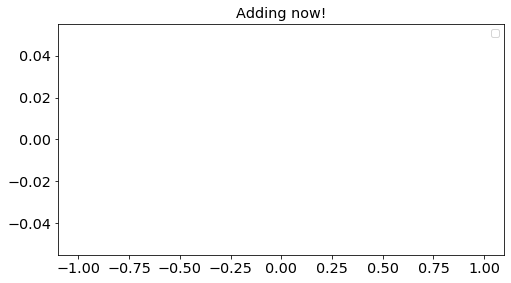

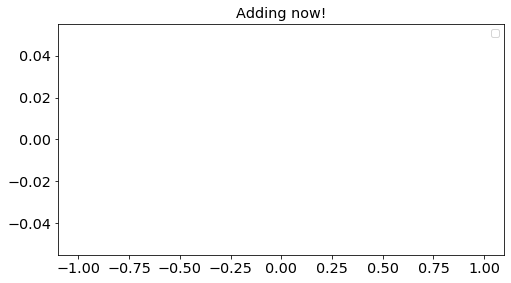

In [63]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-20, 280])    #Vtx X
    #numu_ax1.set_xlim([-140, 140])    #Vtx Y
    #numu_ax1.set_xlim([-10, 1100])    #Vtx Z
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [64]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


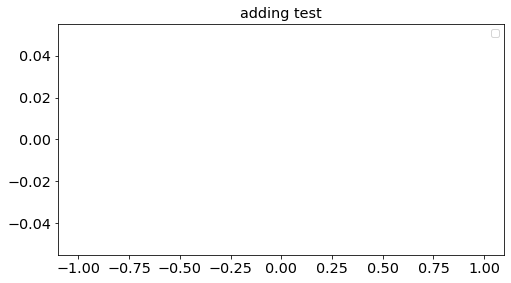

In [65]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_xlim([-20, 280])
#numu_ax1.set_xlim([-140, 140])
#numu_ax1.set_xlim([-10, 1100])
#numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [66]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full true
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full true
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')

### Stat Errors

In [67]:
###NUMU NUE####

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 
    
    weights = { 
                "numu_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  400

1.0
1
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  numu_nue
[]

[]
current_uncertainties
[0 0 0 0 0 0 0 0 0 0]
LOOK HERE FOR DETSYS
None
err numu nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys numu nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

weightSplineTimesTuneTimesPPFX
spline_fix_cv
Series([], Na

In [68]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_nue_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [69]:
if isRun3 == False:    
    """
    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:  
    """
    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [70]:
#############################
##### weightsPPFX ###########  NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  400

1.0
1
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


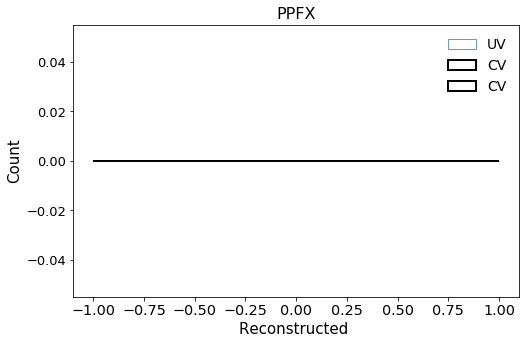

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


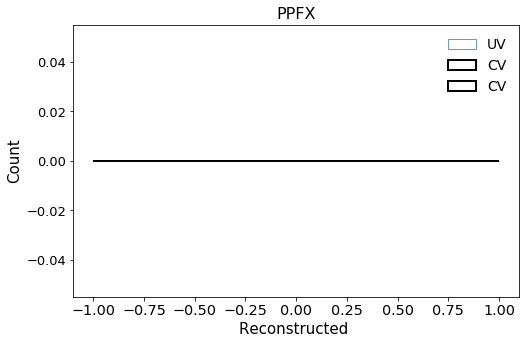

In [71]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)


    plt.show()

In [72]:
#will need to edit this if batching

numu_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [73]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_nue_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [74]:
if isRun3 == False:
    """
    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
if isRun3 == True:
    """
    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [75]:
#############################
##### weightsgenie ###########  NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  400

1.0
1
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


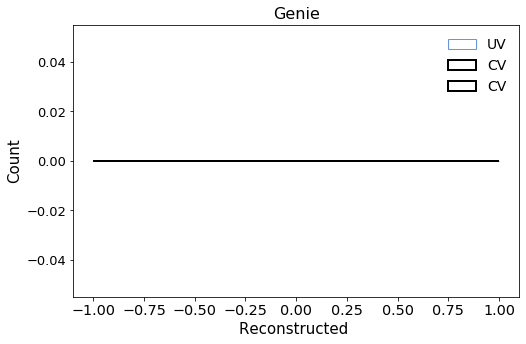

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


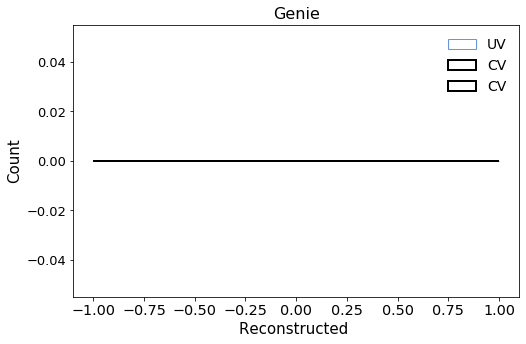

In [76]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [77]:
#will need to edit this if batching

numu_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [78]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_genie.append(sum(masterlist[a]))

final_ncvs_numu_nue_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [79]:
if isRun3 == False:
    """
    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nnue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
if isRun3 == True:
    """
    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """

In [80]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  400

1.0
1
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------

{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


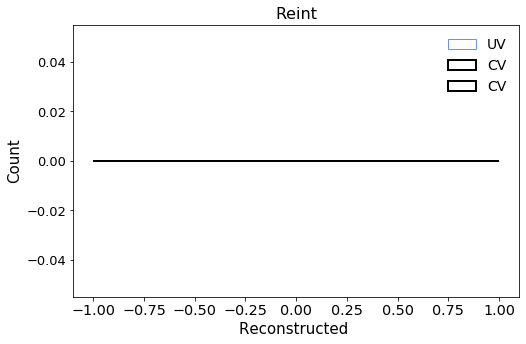

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


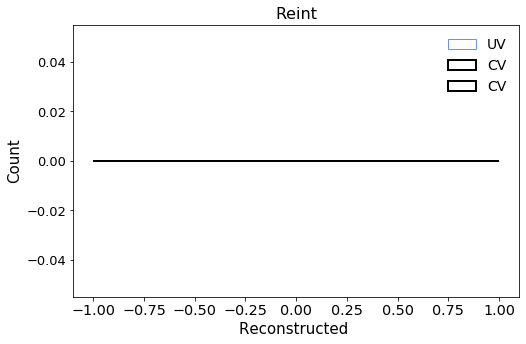

In [81]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [82]:
#will need to edit this if batching

numu_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
  

In [83]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_reint.append(sum(masterlist[a]))

final_ncvs_numu_nue_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [84]:
if isRun3 == False:
    """
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #############################
    #####angleDiff##########
    #######################
    
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #############################
    #####leptonMom##########
    #######################
    
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #############################
    #####angleDiff##########
    #######################
    
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #############################
    #####leptonMom##########
    #######################
    
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


In [85]:
#############################
##### weightsNuMIGeo ###########   NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  400
1.0
2
{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0  and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_nue': 0.01978299467350562}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


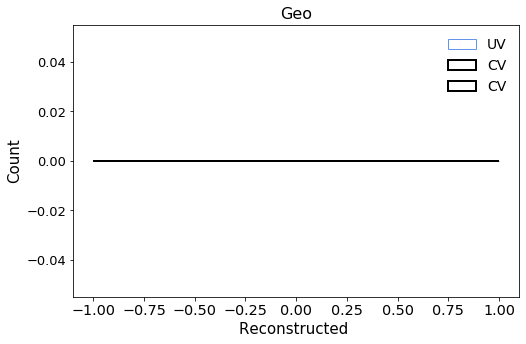

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


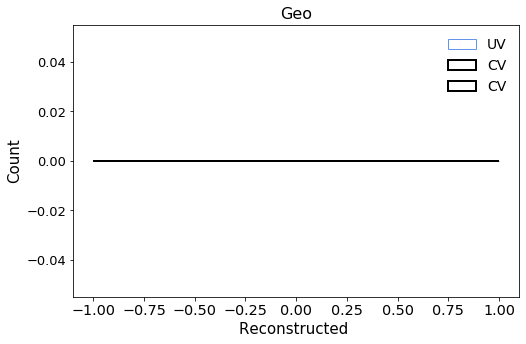

In [86]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [87]:
#will need to edit this if batching

numu_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [88]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_geo.append(sum(masterlist[a]))

final_ncvs_numu_nue_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_nue_geo)):
    final_ns_numu_nue_geo[x] = np.concatenate((final_ns_numu_nue_geo[x][0], final_ns_numu_nue_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [89]:
if isRun3 == False:
    """
    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    ########################
    ####angleDiff##########
    #######################
    

    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    ########################
    ####angleDiff##########
    #######################
    

    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    
    """

## NUMU_DIRT SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
if isRun3 == False:
    DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND
elif isRun3 == True:
    DRT  = '/neutrinoselection_filt_run3b_dirt_overlay'  +ls.APPEND

#actually fetch datasets
numu_dirt  = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_dirt]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", "trk_pfp_id",
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt", "contained_fraction",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['reco_nu_vtx_sce_z', 'trk_sce_end_z_v', 'slnhits', 'pion_e', 'CosmicIP', 'shr_energy_tot_cali', 'reco_e', '_opfilter_pe_veto', 'trk_sce_start_x_v', 'trk_range_muon_mom_v', 'pi0truth_elec_etot', 'CosmicIPAll3D', 'shr_tkfit_dedx_Y', 'trk_llr_pid_score_v', 'true_e_visible', 'proton_e', 'tksh_distance', 'trk_phi', 'contained_fraction', 'reco_nu_vtx_x', 'sub', 'category', '_opfilter_pe_beam', 'trk_mcs_muon_mom_v', 'nu_pdg', 'backtracked_pdg', 'trk_sce_end_y_v', 'ccnc', 'topological_score', 'evnunhits', 'flash_pe', 'npi0', 'evt', 'CosmicDirAll3D', 'mc_pdg', 'muon_e', 'trk_energy_muon', 'nproton', 'npion', 'elec_e', 'nslice', 'slpdg', 'trk_energy_tot', 'run', 'swtrig_pre', 'pi0_e', 'trk_theta', 'slnunhits', 'interaction', 'n_showers_contained', 'isVtxInFiducial', 'reco_nu_vtx_sce_y', 'nmuon', 'slclustfrac', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_y', 'trk_sce_end_x_v', 'reco_nu_vtx_z']


In [6]:
import time
s = time.time()

import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS + PPFX

# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 



for ii, CV in enumerate(uproot_v):
    print("1")
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    print()
    print("2")
    load_data_run123.process_uproot_numu(CV,CVDF)
    print("3")
    if ii == 0:
        print("4")
        numu_dirt =  CVDF

s2 = time.time()

print("runtime = ", s2-s)
#Approx 5 mins

1

2
trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


3
4
runtime =  155.85957264900208


In [7]:
df_v = [numu_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:
numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0", inplace=True)


In [10]:
s = time.time()

df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 
#Run3 = 

runtime =  0.18986892700195312


In [11]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    dirt_pot =  1.42143e+21
    scalingDRT = 0.35
elif isRun3 == True:
    beamon_pot = 5.014E20
    dirt_pot =  1.03226e+21
    scalingDRT = 0.45    

numu_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [12]:
numu_dirt['totweight_data'] = numu_dirt['pot_scale']*numu_dirt['weightSplineTimesTuneTimesPPFX']

In [13]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [14]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [15]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_7332/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  7.25248908996582


In [16]:
#numu_dirt["is_signal"]   = numu_dirt["category"] == 2
#print(numu_mc["is_signal"])

In [17]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [18]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [19]:
#df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
#for i,df in enumerate(df_v):
#    print(df["n_muons_tot"])

In [20]:
#numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and n_showers_contained==0", inplace=True)

In [21]:
#RECO VARIABLE
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)

entry
3527                  [216.6536, 179.14412]
4255                   [878.6665, 946.2457]
4633        [307.1298, 306.15985, 307.9991]
6008                  [472.0022, 456.68082]
6597      [899.77264, 906.25354, 811.46246]
                        ...                
564832               [389.11575, 289.59225]
565244                [151.35966, 88.21207]
565770     [866.66345, 871.2874, 862.18304]
565983     [678.0295, 509.40195, 475.88098]
566221                  [835.3216, 933.008]
Name: trk_sce_end_z_v, Length: 283, dtype: object
entry
3527      0.317174
4255      0.392615
4633      0.399214
6008      0.281314
6597      0.490133
            ...   
564832    0.354059
565244     0.30428
565770    0.165098
565983    0.692385
566221    0.395383
Name: muon_mom, Length: 283, dtype: object

runetime =  0.5177230834960938


In [22]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [23]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)


runetime =  0.435283899307251


In [24]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [25]:
numu_dirt   = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

In [50]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
#if lepton momemtum add (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)

In [51]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.swtrig_pre==1)&(df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False) , True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

Set up complete.

In [52]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_dirt"  : numu_dirt
}

scaling = 1
SPLIT = 1.0

if isRun3 == False:
    pot       =  2e+20
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.65 #0.35
elif isRun3 == True:
    pot       =  5.014e+20
    dirtratio = pot/1.03226e+21
    scalingDRT = 0.45   

weights = {  "numu_dirt": dirtratio* SPLIT * scalingDRT,  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_dirt': 0.09145719451538241}


In [53]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  \
and contained_fraction> 0.95 and topological_score >0.3"
#ENERGY
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
#ANGLE
#NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0'
#NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0'
#LEPTON MOM
NUMU_SEL_QUERY += ' and muon_mom > 0.04 & muon_mom < 5'
NUMU_SEL_QUERY += ' and targetP > 0.04 & targetP < 5'



SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

n_events here =  283

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score >0.3 and muon_mom > 0.04 & muon_mom < 5 and targetP > 0.04 & targetP < 5& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_dirt
--------------------------------------
current sample is:  numu_dirt
current_total  2.031489965499589
2.031489965499588823405474613537080585956573486328125000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  2.0314899654995

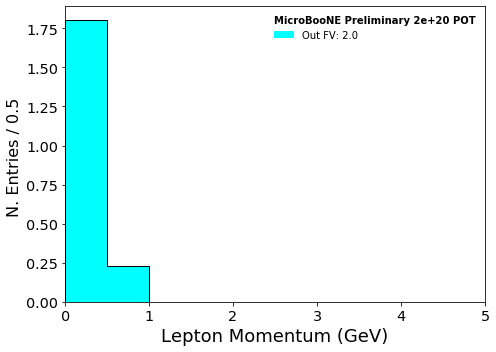

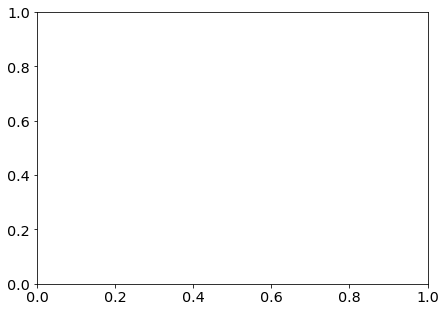

In [54]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',20,(0, 1),"Topological Score"
    #VARIABLE, BINS, RANGE, XTIT = 'trk_llr_pid_score_v',40,(-1.0, 1.0),"LLR PID Score"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_dirt",
        kind="event_category",
        #kind="psrticle_pdg",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


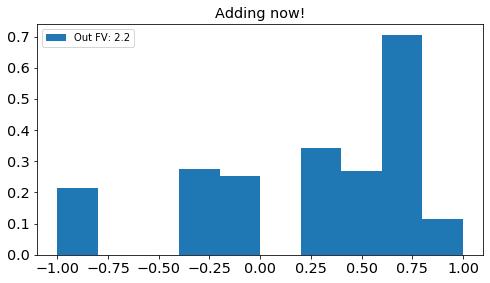

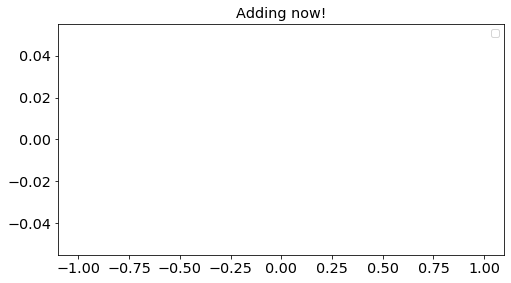

In [61]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    
    #print(varss)

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [62]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

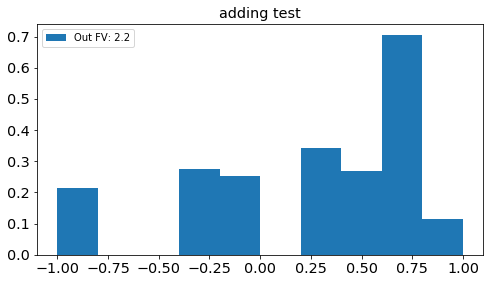

In [63]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 30])

##AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 15])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [64]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [65]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full true
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full true
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Err

In [66]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  197

1.0
1
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score >0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  numu_dirt

LOOK HERE FOR DETSYS
None
err numu dirt: 
[0.04777663 0.         0.         0.04777663 0.04777663 0.04777663
 0.09555325 0.09555325 0.14332988 0.04777663]
detsys numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [2.1408316e-01 

In [67]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_dirt_stat_errs_selected = total_sels

total errs =  [0.04777662740085818, 0.0, 0.0, 0.04777662740085818, 0.04777662740085818, 0.04777662740085818, 0.09555325480171636, 0.09555325480171636, 0.14332988220257456, 0.04777662740085818]
total selected =  [0.21408316493034363, 0.0, 0.0, 0.27666252851486206, 0.25401514768600464, 2.870094162332748e-09, 0.34392037987709045, 0.2679077684879303, 0.7044148445129395, 0.11487027257680893]


In [68]:

if isRun3 == False:
    """
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """

    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errs

In [55]:
############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  283
n_events/2 here =  141.0

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score >0.3 and muon_mom > 0.04 & muon_mom < 5 and targetP > 0.04 & targetP < 5& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0    601  1622  1172  1077   493   170   675   807  1045   243  ...  1000   
1   1072   343   754   564   286   151   152   540   464   158  ...  1000   
2    169     

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.80015945 0.23133039 0.         0.         0.         0.
 0.         0.         0.         0.        ]


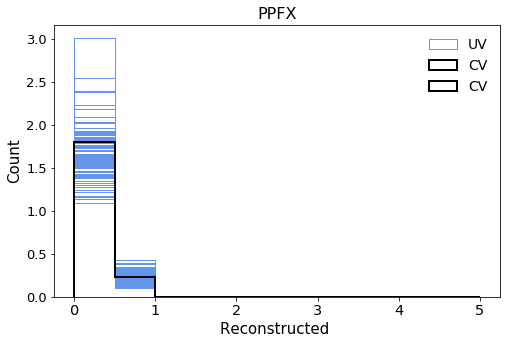

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


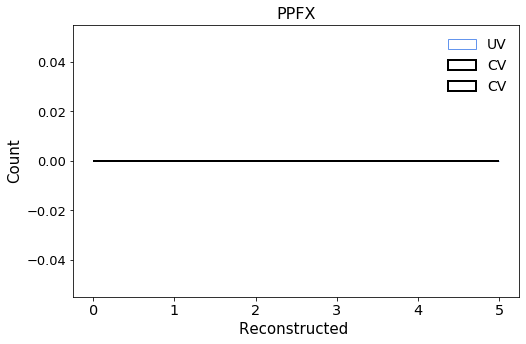

In [56]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    #bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    #bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [57]:
#will need to edit this if batching

numu_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [58]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_numu_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [59]:
if isRun3 == False:
    """
    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """

    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    """
    
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    
elif isRun3 == True:
    """
    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')


    ###########################################

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    """
    
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    

In [36]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  283
n_events/2 here =  141.0

1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score >0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0   2973   392   991  1021   638  2093  1545   874  1298  1167  ...  1000   
1    999   421   573  1385  1037   542  1338   484  1

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0.16581286 0.08975147 0.         0.         0.         0.
 0.16705608 0.10638881 0.42249584 1.07998502]


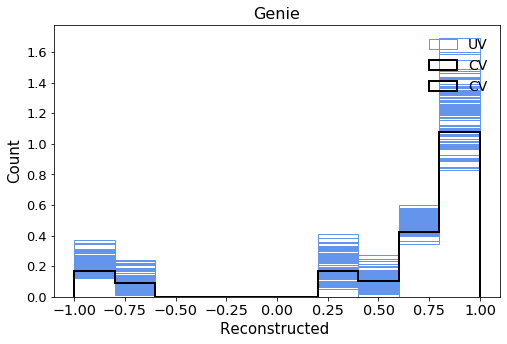

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


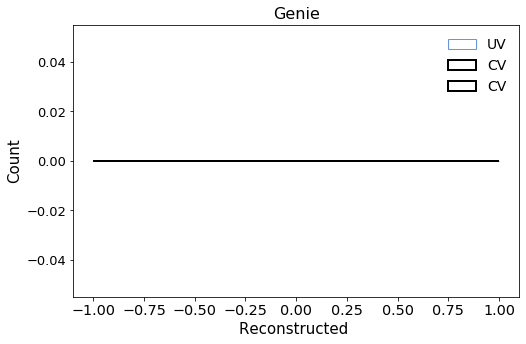

In [37]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [38]:
#will need to edit this if batching

numu_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [39]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_genie.append(sum(masterlist[a]))

final_ncvs_numu_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


     0     1     2     3     4     5     6     7     8     9    ...   590  \
0   2973   392   991  1021   638  2093  1545   874  1298  1167  ...  1000   
1    999   421   573  1385  1037   542  1338   484  1430   494  ...  1000   
2    942   607   848  1179  1115   988  1251  1026   391   855  ...  1000   
3   1365  1075   871  1300  1109  1416  1168  1202  1322  1321  ...  1000   
4   1220   403   406  1671   898   714  1361   535  1783   582  ...  1000   
5   1646   408  1161   646   475  1542   986   786   748   922  ...  1000   
6    785   664   783  1097  1426   855  1307  1142   623   826  ...  1000   
7   1076  1001   706  1183  1510  1300   620  1141   943  1007  ...  1000   
8   1114  1080  1071   640   838   471   802  1100   369   776  ...  1000   
9    560   271   150   981   619   321   943   744   509   393  ...  1000   
10  1089  1660  1733   899   571   865   860   695   967  1088  ...  1000   
11  1335  1053   869  1270  1085  1387  1141  1174  1292  1291  ...  1000   

In [40]:
if isRun3 == False:
    """
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


In [41]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  283
n_events/2 here =  141.0
weightsReint
1.0
1
{'numu_dirt': 0.09145719451538241}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score >0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   990  \
0   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1   1000  1000  1000  1000  1000  1000  1

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0.16581286 0.08975147 0.         0.         0.         0.
 0.16705608 0.10638881 0.42249584 1.07998502]


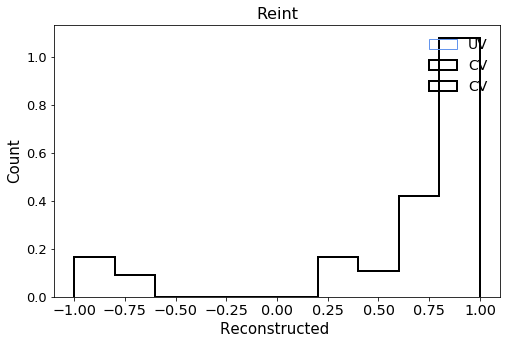

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


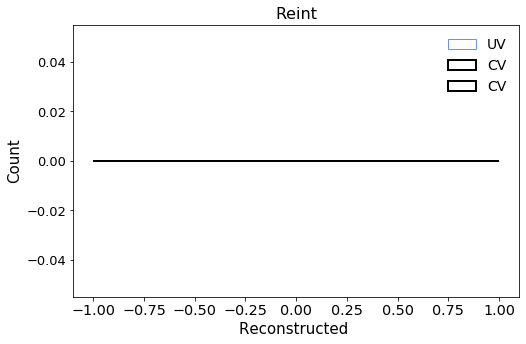

In [42]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [43]:
#will need to edit this if batching

numu_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [44]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_reint.append(sum(masterlist[a]))

final_ncvs_numu_dirt_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [83]:
if isRun3 == False:
    """
    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    
    #################
    ###angleDiff#####
    #################

    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """

    
    #################
    ###angleDiff#####
    #################

    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


In [84]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
    
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  197
n_events/2 here =  98.0
1.0
2
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score >0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 and cosNu_Angle_Numi_Muon >-1.0 and cosNu_Angle_Numi_Muon <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vt

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0.21408316 0.         0.         0.27666253 0.25401518 0.
 0.34392035 0.26790774 0.70441473 0.11487031]


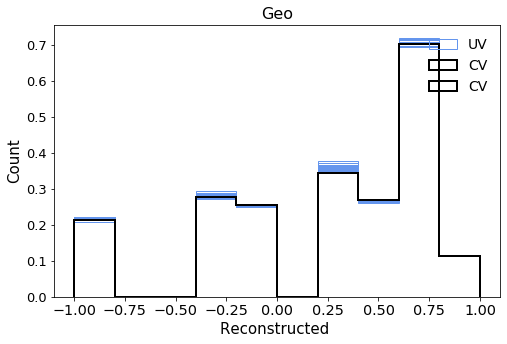

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


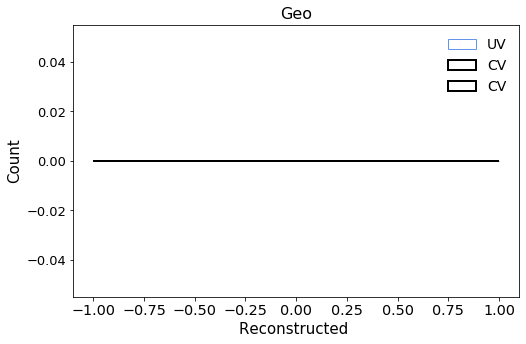

In [85]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    #bin_centers = np.arange(0.25, 5.25, 0.5)
    #bins = np.arange(0, 5.5, 0.5)
    bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [86]:
#will need to edit this if batching

numu_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    #numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    #numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    #numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [87]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_geo.append(sum(masterlist[a]))

final_ncvs_numu_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_numu_dirt_geo)):
    final_ns_numu_dirt_geo[x] = np.concatenate((final_ns_numu_dirt_geo[x][0], final_ns_numu_dirt_geo[x][1]))
    
    
print(final_ns_numu_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

[2.17536410e-01 0.00000000e+00 0.00000000e+00 2.74486382e-01
 2.51540664e-01 2.72861041e-09 3.61024684e-01 2.69284090e-01
 7.04022803e-01 1.14091124e-01 2.12417427e-01 0.00000000e+00
 0.00000000e+00 2.84156271e-01 2.54134256e-01 2.86030334e-09
 3.58539412e-01 2.68690068e-01 7.06090150e-01 1.15283605e-01]


In [88]:
if isRun3 == False:
    """
    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    
    #####################
    ###angleDiff########
    ####################

    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    
    """
    ####################
    ###leptonMom########
    ####################

    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    """


## NUMU_EXT

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
if isRun3 == False:
    EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
elif isRun3 == True:
    EXT  = '/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND

#actually fetch datasets
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_ext]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre", 
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction", 
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali", "proton_e", "elec_e",
        "reco_e","trk_energy_tot","n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['reco_nu_vtx_sce_y', 'reco_e', 'trk_mcs_muon_mom_v', 'nu_pdg', 'backtracked_pdg', 'trk_llr_pid_score_v', 'slpdg', 'muon_e', 'run', 'mc_pdg', 'trk_range_muon_mom_v', 'flash_pe', 'tksh_distance', 'pion_e', 'npi0', 'reco_nu_vtx_y', 'reco_nu_vtx_sce_z', 'slnhits', 'trk_theta', 'evt', 'npion', 'n_showers_contained', '_opfilter_pe_beam', 'nslice', 'interaction', 'trk_sce_end_y_v', 'CosmicIPAll3D', 'nproton', 'contained_fraction', 'proton_e', 'trk_sce_start_x_v', '_opfilter_pe_veto', 'CosmicIP', 'trk_energy_muon', 'nmuon', 'evnunhits', 'isVtxInFiducial', 'CosmicDirAll3D', 'shr_energy_tot_cali', 'reco_nu_vtx_sce_x', 'trk_sce_end_z_v', 'shr_tkfit_dedx_Y', 'category', 'swtrig_pre', 'sub', 'slclustfrac', 'elec_e', 'slnunhits', 'topological_score', 'pi0truth_elec_etot', 'pi0_e', 'true_e_visible', 'reco_nu_vtx_x', 'reco_nu_vtx_z', 'trk_energy_tot', 'ccnc', 'trk_sce_end_x_v', 'trk_phi']


In [6]:
import time
s = time.time()

import pandas as pandas

ext_var  = numu_variables + numu_varMC  ##added second part

# This needs modifications (add variables from above)
uproot_v = [numu_ext] 
var_v    = [ext_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_ext = CVDF

s2 = time.time()
print(s2 - s)
#Approx 3 mins

trk_llr_pid_v  [[] [] [] ... [0.97052354 0.46686205] [] [0.9231277]]
trk_score_v  [[] [] [] ... [1.0 0.010001138] [] [0.9994478]]
Here:
trk_range_muon_mom_v  [[] [] [] ... [0.5356459 0.08237955] [] [0.41866612]]
trk_mcs_muon_mom_v  [[] [] [] ... [0.4799978 14.999432] [] [0.8129949]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


591.2177329063416


In [7]:
if isRun3 == False:
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
elif isRun3 == True:
    extratio  = 10363728.0/32878305.25
    scalingEXT = 0.98

numu_ext['pot_scale'] = extratio * scalingEXT

In [8]:
numu_ext['totweight_data'] = numu_ext['pot_scale']

In [9]:
df_v = [numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    #df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_7335/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  86.1117832660675


In [12]:
#numu_ext["is_signal"]   = numu_ext["category"] == 2

In [12]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [13]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [14]:
numu_ext.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0", inplace=True)


In [15]:
#RECO VARIABLE
df_v = [numu_ext]
    
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)

entry
3254                    [623.5206, 605.3592]
6047         [827.39435, 808.5187, 821.0348]
9098        [291.9362, 327.65396, 245.72343]
18640                   [573.7536, 527.9679]
20643                   [158.9426, 86.28496]
                         ...                
3201974                  [552.0224, 525.887]
3202579      [586.32043, 561.3431, 556.3789]
3206252    [287.89584, 255.76543, 260.67233]
3209792               [743.06006, 742.64233]
3210076      [969.3807, 739.5761, 884.46936]
Name: trk_sce_end_z_v, Length: 1519, dtype: object
entry
3254        0.25293
6047        0.18796
9098       0.468977
18640      0.470768
20643      0.423149
             ...   
3201974    0.464931
3202579    0.271081
3206252    0.335463
3209792    0.237128
3210076    0.396571
Name: muon_mom, Length: 1519, dtype: object

runetime =  3.218426465988159


In [16]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [17]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)


runetime =  1.3303751945495605


In [18]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
df_v = [numu_ext]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5) 
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
#if lepton momemtum add (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)

Set up complete.

In [46]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_ext"  : numu_ext
}

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98

if isRun3 == False:
    pot =  2e+20
    extratio  = 5268051/9199232.74 
elif isRun3 == True:
    pot =  5.014e+20
    extratio  = 10363728.0/32878305.25


weights = {   "ext" : extratio * SPLIT * scalingEXT, 
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'ext': 0.3089104916683624}


In [47]:
"""
#No true query as data
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  \
and contained_fraction> 0.95 and topological_score > 0.3"
#ENERGY
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#ANGLE
#NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0'
#LEPTON MOM
NUMU_SEL_QUERY += ' and muon_mom > 0.04 & muon_mom < 5'

#no truth as is data

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [48]:
test = np.nansum(numu_ext.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(numu_ext.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0.0
total signal events = 52.20587309195325


No handles with labels found to put in legend.


n_events here =  1519

1.0
1
{'ext': 0.3089104916683624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and muon_mom > 0.04 & muon_mom < 5& muon_mom <= 5 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_ext
--------------------------------------
current_plotted_variable  [0.3929226 0.25002706 0.16607189 0.38815674 0.17665814 0.4802383
 0.20193179 0.4637235 0.4749276 0.8715586 0.21973763 0.22945042 0.23459078
 0.39440835 0.2703063 0.5044007 0.38380742 0.2869405 0.5231505 0.30163738
 0.51997393 0.27827248 0.41534382 0.23056236 0.47

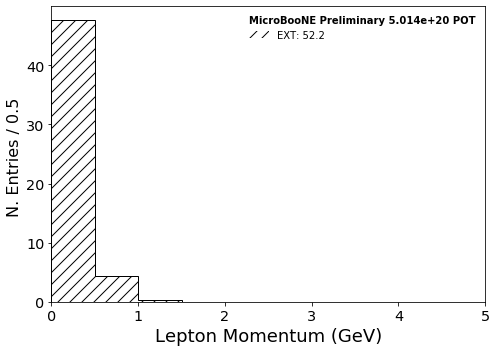

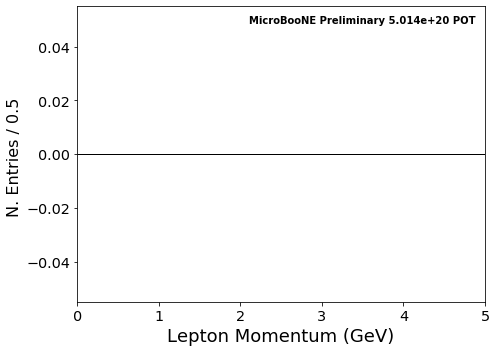

In [49]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }


    if isRun3 == False:
        pot =  2e+20
        extratio  = 5268051/9199232.74 
        scalingEXT = 0.98
    elif isRun3 == True:
        pot =  5.014e+20
        extratio  = 10363728.0/32878305.25
        scalingEXT = 0.98
    
    # NUE
    weights = { "ext" : extratio * SPLIT * scalingEXT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',20,(0, 1),"Topological Score"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


[array([0.3929226, 0.25002706, 0.16607189, 0.38815674, 0.17665814,
       0.4802383, 0.20193179, 0.4637235, 0.4749276, 0.8715586, 0.21973763,
       0.22945042, 0.23459078, 0.39440835, 0.2703063, 0.5044007,
       0.38380742, 0.2869405, 0.5231505, 0.30163738, 0.51997393,
       0.27827248, 0.41534382, 0.23056236, 0.4777388, 0.30248168,
       0.2729322, 0.3140473, 0.19853994, 0.321879, 0.23761068, 0.20838541,
       0.233386, 0.22124833, 0.6493522, 0.31002286, 0.23308359, 0.2659782,
       0.23007219, 0.2353928, 0.4056882, 0.2295318, 0.3290563, 0.2504604,
       0.33646417, 0.35431483, 0.5235943, 0.48748538, 0.15374452,
       1.1530981, 0.26794636, 0.21612635, 0.16467308, 0.45814818,
       0.15590909, 0.18472067, 0.23516396, 0.47238594, 0.21525833,
       0.19099742, 0.15337536, 0.25804776, 0.26153487, 0.15050216,
       0.19678889, 0.29109988, 0.6569021, 0.4092619, 0.22859265, 0.220277,
       0.17678453, 0.4937178, 0.5193088, 0.45099014, 0.27538428,
       0.18093799, 0.25076863, 0

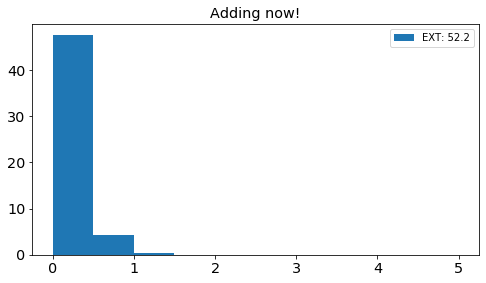

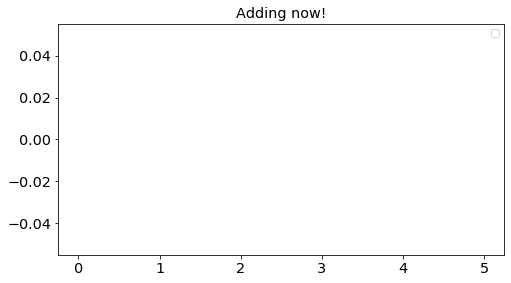

In [50]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    
    print(varss)

    numu_stacked = numu_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [51]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

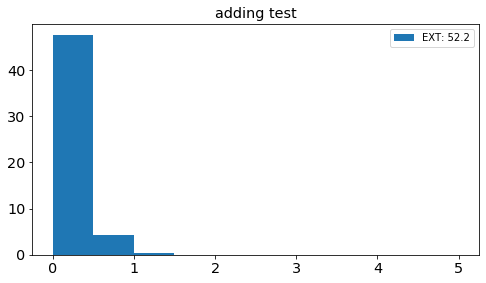

In [52]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = labss


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 300])

#AngleDiff
#numu_ax1.set_xlim([-1, 1])
#numu_ax1.set_ylim([0, 80])

numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [53]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [54]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Errors

[6.89726147 2.07960258 0.55579717 0.         0.         0.
 0.         0.         0.         0.        ]


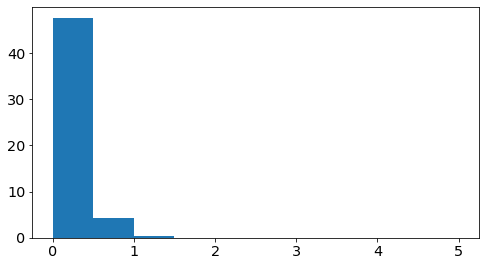

In [55]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 500])


numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


numu_ext_stat_errs = np.sqrt(numu_stacked[0])

print(numu_ext_stat_errs)

In [56]:
if isRun3 == False:
    """
    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    """
    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    """
    
    
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    
elif isRun3 == True:
    """
    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    """
    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
           (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)    fmt ='% s')
    """
    
    
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    

## NUMU_DATA SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
if isRun3 == False:
    BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
elif isRun3 == True:
    BNB  = '/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND

#actually fetch datasets
numu_data  = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_data]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction", 
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali", "proton_e", "elec_e",
        "reco_e","trk_energy_tot","n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['nu_pdg', 'trk_sce_start_x_v', 'category', 'reco_nu_vtx_sce_x', 'interaction', 'reco_nu_vtx_y', 'slpdg', 'topological_score', 'true_e_visible', 'CosmicDirAll3D', 'mc_pdg', 'pion_e', 'pi0_e', 'elec_e', 'sub', 'swtrig_pre', 'trk_sce_end_x_v', 'trk_theta', 'trk_energy_muon', 'trk_range_muon_mom_v', 'muon_e', 'nproton', 'isVtxInFiducial', 'reco_e', 'n_showers_contained', 'reco_nu_vtx_z', 'tksh_distance', 'reco_nu_vtx_x', 'flash_pe', '_opfilter_pe_beam', 'slclustfrac', 'proton_e', 'shr_tkfit_dedx_Y', 'npion', 'run', 'trk_sce_end_z_v', 'evnunhits', 'backtracked_pdg', 'contained_fraction', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'trk_phi', 'pi0truth_elec_etot', 'slnunhits', 'CosmicIP', 'nslice', 'evt', 'trk_energy_tot', 'CosmicIPAll3D', 'nmuon', 'shr_energy_tot_cali', 'trk_llr_pid_score_v', 'trk_mcs_muon_mom_v', 'npi0', 'slnhits', '_opfilter_pe_veto', 'ccnc', 'trk_sce_end_y_v']


In [6]:
import time
s = time.time()

import pandas as pandas

data_var  = numu_variables + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_data] 
var_v    = [data_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_data = CVDF

s2 = time.time()
print(s2 - s)
#Approx 3 mins

trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


138.24137926101685


In [7]:
numu_data['pot_scale'] = [1 for x in range(len(numu_data))]

In [8]:
numu_data['totweight_data'] = numu_data['pot_scale']

In [9]:
df_v = [numu_data]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_data]
for i,df in enumerate(df_v):  
    #df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_8905/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  9.951351404190063


In [12]:
#numu_data["is_signal"]   = numu_data["category"] == 2

In [13]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [14]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [15]:
numu_data.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0", inplace=True)


In [16]:
#RECO VARIABLE
df_v = [numu_data]
    
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)

entry
490                                    [156.18512, 246.7878]
1186                                    [656.6905, 601.3882]
1236                                   [831.45514, 857.1822]
1425                                   [394.6405, 395.75952]
1594                         [476.1753, 251.88936, 242.8688]
                                 ...                        
1103342    [437.044, 446.21927, 422.78644, 378.04797, 366...
1103440                               [297.51132, 121.85714]
1103554                               [258.51245, 249.91241]
1103612                       [687.439, 641.95935, 639.3839]
1104343           [952.66113, 889.01483, 773.8401, 790.5579]
Name: trk_sce_end_z_v, Length: 3490, dtype: object
entry
490        0.361931
1186       0.318456
1236       0.215977
1425       0.211738
1594       0.706448
             ...   
1103342    0.570996
1103440     0.54621
1103554    0.345876
1103612    0.381335
1104343    0.644393
Name: muon_mom, Length: 3490, dtype: object

r

In [17]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [18]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)


runetime =  3.4890544414520264


In [19]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
df_v = [numu_data]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
#if lepton momemtum add (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)

Set up complete.

In [29]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_data"  : numu_data
}

if isRun3 == False:
    pot       =  2e+20
elif isRun3 == True:
    pot       =  5.014e+20    

SPLIT = 1.0
scaling = 1

weights = { }

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{}


In [30]:
"""
#No true as is data
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  \
and contained_fraction> 0.95 and topological_score > 0.3"
#ENERGY
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#ANGLE
NUMU_SEL_QUERY += ' and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0'
#LEPTON MOM
#NUMU_SEL_QUERY += ' and muon_mom > 0.04 & muon_mom < 5'


SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

No handles with labels found to put in legend.


n_events here =  3490

1.0
1
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3 and cosNu_Angle_Numi_Muon_Reco >-1.0 and cosNu_Angle_Numi_Muon_Reco <1.0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_data
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
--------------

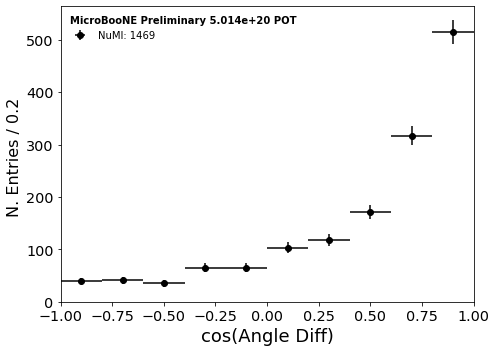

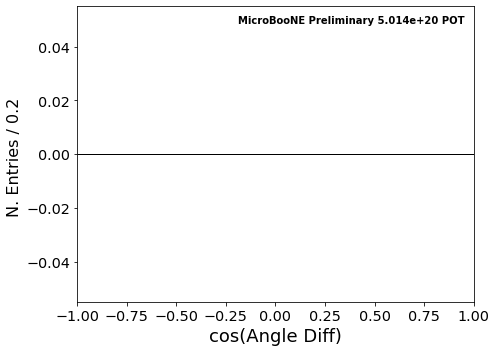

In [31]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_data.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_data.iloc[start:end]

    samples = {
        "numu_data": sample_set 
    }

    if isRun3 == False:
        pot =  2e+20 
    elif isRun3 == True:
        pot =  5.014e+20 
        
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',20,(0, 1),"Topological Score"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


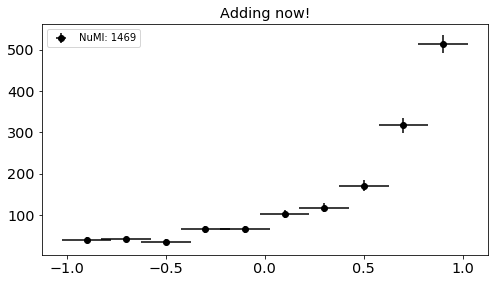

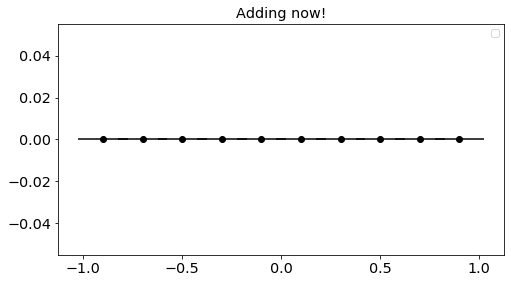

In [32]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom, muons
    #current_bincenters =  np.arange(0.25, 5.25, 0.5)
    #current_bin_size = 0.5
    #current_bincenters =  np.arange(0.5, 5.5, 1)
    #current_bin_size = 1
    ########################
    #numu_ax1.set_xlim([-20, 280])    #X
    #current_bincenters =  np.arange(-17.5, 282.5, 5)
    #current_bin_size = 5
    ########################
    #numu_ax1.set_xlim([-140, 140])    #Y
    #current_bincenters =  np.arange(-137.5, 142.5, 5)
    #current_bin_size = 5
    ########################
    #numu_ax1.set_xlim([-10, 1100])    #Z
    #current_bincenters =  np.arange(0, 1110, 20)
    #current_bin_size = 20
    ########################
    #numu_ax1.set_xlim([0, 1])    #Cont
    #current_bincenters =  np.arange(0.025, 1, 0.05)
    #current_bin_size = 0.05
    ########################
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    current_bin_size = 0.25
    
    numu_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [33]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[ 6.32455532  6.40312424  5.91607978  8.06225775  8.06225775 10.14889157
 10.86278049 13.07669683 17.80449381 22.6715681 ]


[ 40  41  35  65  65 103 118 171 317 514]


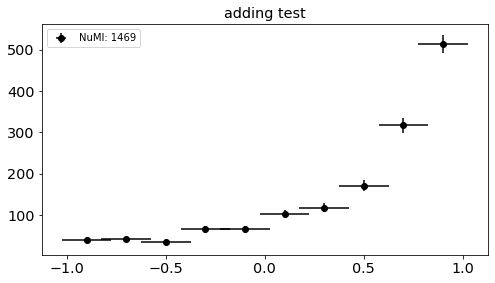

In [34]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = labss

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 4000])

#AngleDiff
#numu_ax1.set_xlim([-1,1])
#numu_ax1.set_ylim([0, 900])

print(varss_tot)

numu_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [35]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    #######full trueE
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    #######full trueE
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
